# Value-at-Risk Evaluation and Density Forecasting

## Kevin Sheppard

# Today 

* Value-at-Risk
  * Model evaluation
* Density Forecasting
* Expected Shortfall

In [1]:
import math

import matplotlib.pyplot as plt
import mfe
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from arch import arch_model
from arch.univariate import EWMAVariance, ZeroMean
from mfe.slides import plot, summary, pretty

mfe.full_setup()
mfe.outputs["pres"]()

In [2]:
import pandas as pd

with pd.HDFStore("univariate-volatility-data.h5", "r") as store:
    sp500 = store.get("sp500")

# Evaluation of Value-at-Risk Models

* Generalized Mincer-Zarnowitz

$$\text{HIT}_{t+h}=\gamma_{0}+\gamma_{1}VaR_{t+h|t}+\gamma_{2}\text{HIT}_{t}+\gamma_{3}\text{HIT}_{t-1}+\ldots+\gamma_{K}\text{HIT}_{t-K+1}+\eta_t$$

* Bernoulli

$$ I_{[r_t<q_t]} \sim \text{Bernoulli}(\alpha)$$

* Christoffersen's Conditional Bernoulli Test

$$ \left. I_{[r_t<q_t]} \right| r_{t-1},q_{t-1} \sim \text{Bernoulli}(\alpha)$$

* Logit/Probit improvement of GMZ

$$ \left. I_{[r_t<q_t]}  \right| \mathcal{F}_{t-1} \sim \text{Bernoulli}(\alpha)$$

In [3]:
# * Daily, Weekly
# * 1%, 5%
# * 50-50 split
# * RM, GJR-GARCH, WHS


def single(x, lam, alpha):
    x = np.asarray(x)
    t = x.shape[0]
    w = lam ** np.arange(t)[::-1] * (1 - lam) / (1 - lam ** t)
    idx = np.argsort(x)
    cw = np.cumsum(w[idx])
    loc = np.amin(np.argwhere(cw > alpha))
    return x[idx][loc]


def whs(s, alpha, lam=0.9, window=252):
    t = s.shape[0]
    out = {}
    for i in range(window, t):
        out[s.index[i]] = single(s.iloc[i - window : i], lam, alpha)
    out_s = pd.Series(out)
    return -out_s.reindex(s.index)


df_data = {}
for lam in (0.9, 0.95, 0.975, 0.999):
    df_data[rf"$\lambda={lam}$"] = whs(sp500, 0.05, lam=lam)
df = pd.DataFrame(df_data).dropna()

alpha = 0.025
sp500_weekly = (
    100 * (1 + sp500 / 100.0).cumprod().resample("W").last().pct_change().dropna()
)
rm = ZeroMean(sp500_weekly, volatility=EWMAVariance(0.97)).fit()
rm_var = -rm.conditional_volatility * stats.norm.ppf(alpha)
t = sp500_weekly.shape[0]
last = sp500_weekly.index[t // 2]
gjr_weekly = arch_model(sp500_weekly, o=1, dist="skewt").fit(disp="off", last_obs=last)
vol = np.sqrt(gjr_weekly.forecast(start=last, align="target", reindex=True).variance)
gjr_q = gjr_weekly.model.distribution.ppf(alpha, gjr_weekly.params.iloc[-2:])
gjr_weekly_var = -vol * gjr_q
gjr_weekly_var = gjr_weekly_var.dropna()
weighted_hs_var = whs(sp500_weekly, alpha, lam=0.975, window=52).dropna()
weekly_vars = pd.concat([rm_var, gjr_weekly_var, weighted_hs_var], 1).dropna()
weekly_vars.columns = ["RM", "GJR", "WHS"]

# Weekly VaRs for S&P 500

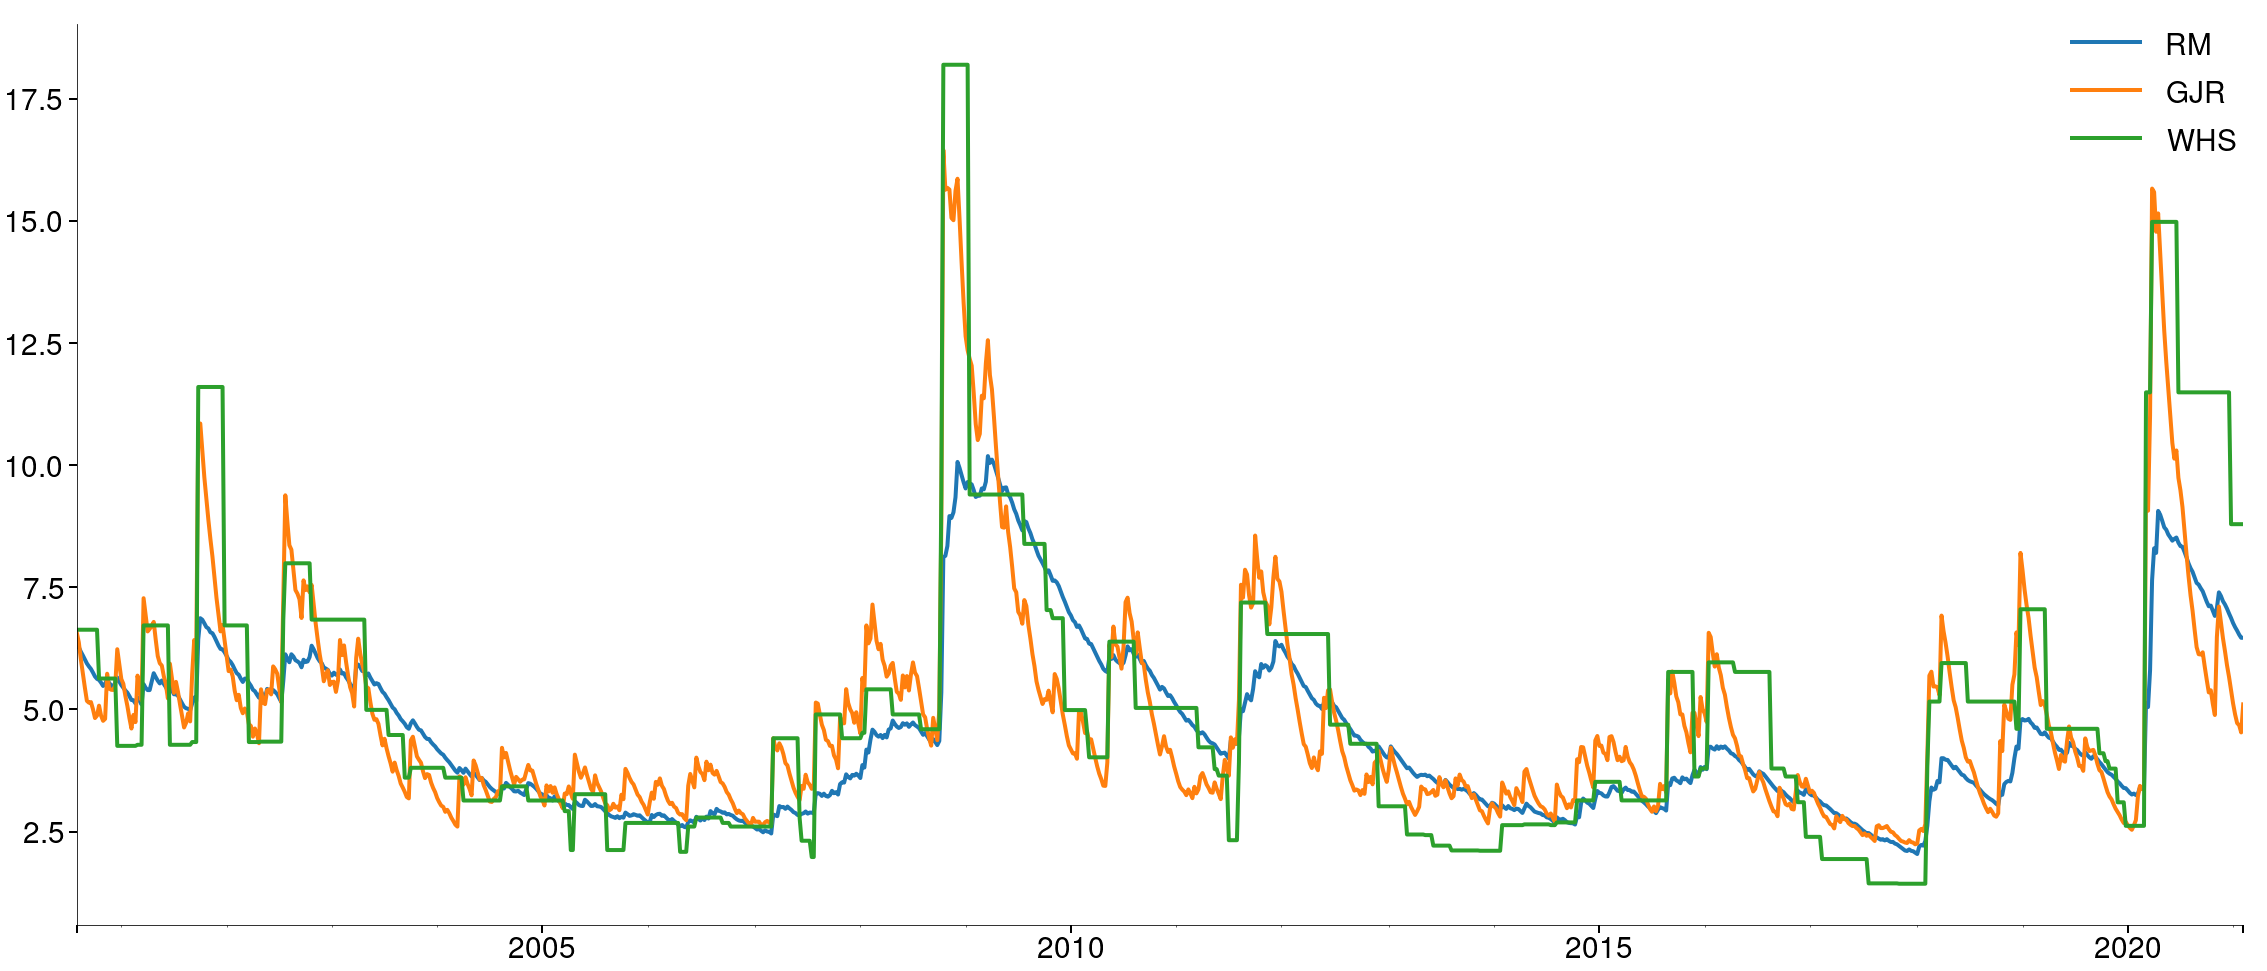

In [4]:
plot(weekly_vars)

# Evaluation: GMZ Regression

* Standard GMZ

$$\text{HIT}_{t+h}=\gamma_{0}+\gamma_{1}VaR_{t+h|t}+\gamma_{2}\text{HIT}_{t}+\gamma_{3}\text{HIT}_{t-1}+\ldots+\gamma_{K}\text{HIT}_{t-K+1}+\eta_t$$

* Called Dynamic Quantile Regression or HIT Test
* $H_0:\gamma_j=0 \,\,\forall j$


In [5]:
oos = sp500_weekly.loc[weekly_vars.index]
weekly_vars
var_exceed = oos.to_numpy()[:, None] < -weekly_vars
hits = var_exceed - alpha

In [6]:
from statsmodels.regression.linear_model import OLS


def gmz(hits, value_at_risks, col, lags=3):
    s = hits[col]
    v = value_at_risks[col]
    c = v.copy()
    c.loc[:] = 1
    x = pd.concat([c, v] + [s.shift(lag + 1) for lag in range(lags)], 1)
    common = pd.concat([s, x], 1).dropna()
    common.columns = ["HIT", "const", "VaR"] + [f"HIT.L{i}" for i in range(1, lags + 1)]
    res = OLS(common.iloc[:, 0], common.iloc[:, 1:]).fit(cov_type="HC0")
    return res


def joint_test(res):
    return pd.DataFrame(
        {"stat": [res.fvalue], "P-value": [res.f_pvalue]}, index=["Joint Test"]
    )

# GMZ for Skew $t$ GJR

In [7]:
gjr_res = gmz(hits, weekly_vars, "GJR")
summary(gjr_res)

,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0133,0.010,1.305,0.192,-0.007,0.033
VaR,-0.0020,0.002,-1.240,0.215,-0.005,0.001
HIT.L1,0.0737,0.054,1.374,0.169,-0.031,0.179
HIT.L2,0.0022,0.034,0.064,0.949,-0.064,0.069
HIT.L3,0.0075,0.031,0.241,0.810,-0.054,0.069


In [8]:
joint_test(gjr_res)

,stat,P-value
Joint Test,1.146883,0.332939


# GMZ for RiskMetrics

In [9]:
rm_res = gmz(hits, weekly_vars, "RM")
summary(rm_res)

,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0458,0.015,3.149,0.002,0.017,0.074
VaR,-0.0082,0.002,-3.469,0.001,-0.013,-0.004
HIT.L1,0.0605,0.051,1.184,0.236,-0.040,0.161
HIT.L2,0.0926,0.057,1.637,0.102,-0.018,0.203
HIT.L3,0.0328,0.044,0.740,0.459,-0.054,0.120


In [10]:
joint_test(rm_res)

,stat,P-value
Joint Test,5.022963,0.000517


# GMZ for WHS

In [11]:
whs_res = gmz(hits, weekly_vars, "WHS")
summary(whs_res)

,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0325,0.011,2.930,0.003,0.011,0.054
VaR,-0.0050,0.001,-3.570,0.000,-0.008,-0.002
HIT.L1,0.0853,0.053,1.602,0.109,-0.019,0.190
HIT.L2,-0.0117,0.030,-0.392,0.695,-0.070,0.047
HIT.L3,0.0589,0.047,1.254,0.210,-0.033,0.151


In [12]:
joint_test(whs_res)

,stat,P-value
Joint Test,4.872636,0.000676


# Evaluation: Unconditional Bernoulli Testing

* Likelihood of $T$ exceedences 

$$l(\alpha;\widetilde{\text{HIT}}_{t})=\sum_{t=1}^{T}{\widetilde{\text{HIT}}_{t}}\ln{\alpha}+\left(1-\widetilde{\text{HIT}}_{t}\right)\ln{1-\alpha} $$

* $\widetilde{\text{HIT}}$ is the indicator for a violation
* Easy to conduct a LR test  

$$LR=2(l(\hat{\alpha};\widetilde{\text{HIT}})-l(\alpha_{0};\widetilde{\text{HIT}}))\sim\chi_{1}^{2}$$

In [13]:
alpha_hat = var_exceed.mean(0)
lrs = {}
for col in var_exceed:
    null = stats.bernoulli(alpha).logpmf(var_exceed[col]).sum()
    alt = stats.bernoulli(alpha_hat[col]).logpmf(var_exceed[col]).sum()
    stat = 2 * (alt - null)
    lrs[col] = pd.Series(
        {"alpha": alpha_hat[col], "LR": stat, "P_value": 1 - stats.chi2(1).cdf(stat)}
    )
bernoulli_lrs = pd.DataFrame(lrs).T.sort_index()

In [14]:
bernoulli_lrs

,alpha,LR,P_value
GJR,0.028945,0.651270,0.419659
RM,0.035481,4.280032,0.038563
WHS,0.033613,2.947361,0.086018


# Conditional Bernoulli Test
## Christoffersen's test

* Probability of a violation is independent of previous violation
* Leads to conditional Bernoulli distribution
* Has a close form expression
* Key inputs all depend on pairs $I_{[r_t<q_t]}$ and $I_{[r_{t-1}<q_{t-1}]}$ 

In [15]:
cond_lrs = {}
for col in var_exceed:
    lag = var_exceed[col].iloc[:-1].shift(1)
    curr = var_exceed[col].iloc[1:]
    n00 = ((1 - lag) * (1 - curr)).sum()
    n10 = ((1 - lag) * (curr)).sum()
    n01 = ((lag) * (1 - curr)).sum()
    n11 = ((lag) * (curr)).sum()
    p11 = alpha
    p00 = 1 - alpha
    p11_hat = n11 / (n11 + n01)
    p00_hat = n00 / (n00 + n10)
    null = (
        n11 * np.log(p11)
        + n01 * np.log(1 - p11)
        + n00 * np.log(p00)
        + n10 * np.log(1 - p00)
    )
    alt = (
        n11 * np.log(p11_hat)
        + n01 * np.log(1 - p11_hat)
        + n00 * np.log(p00_hat)
        + n10 * np.log(1 - p00_hat)
    )
    stat = 2 * (alt - null)
    pval = 1 - stats.chi2(2).cdf(stat)
    cond_lrs[col] = pd.Series({"LR": stat, "P_value": pval})
christoffersen_lrs = pd.DataFrame(cond_lrs).T.sort_index()

In [16]:
christoffersen_lrs

,LR,P_value
GJR,4.000991,0.135268
RM,8.109426,0.017340
WHS,7.424546,0.024422


# Evaluation: Using Logit to improve GMZ

* Same model as GMZ
* Exploit structure of exceedence to estimate using MLE
* Requires ensuring conditional probability is always $\in(0,1)$
  * Logit uses logistic function $ \Lambda\left(\cdot\right)$
  * Probit uses normal cdf  $ \Phi\left(\cdot\right)$

In [17]:
from statsmodels.api import Logit


def gmz_logit(hits, value_at_risks, col, lags=3):
    s = hits[col].astype(float)
    v = value_at_risks[col]
    c = v.copy()
    c.loc[:] = 1
    x = pd.concat([c, v] + [s.shift(lag + 1) for lag in range(lags)], 1)
    common = pd.concat([s, x], 1).dropna()
    common.columns = ["HIT", "const", "VaR"] + [f"HIT.L{i}" for i in range(1, lags + 1)]
    res = Logit(common.iloc[:, 0], common.iloc[:, 1:]).fit(cov_type="HC0", disp=False)
    return res


def joint_logit_stat(res):
    exp_val = np.log(alpha / (1 - alpha))
    r = np.eye(5)
    q = np.zeros(5)
    q[0] = exp_val
    stat = res.wald_test((r, q))
    return pd.DataFrame(
        {"stat": [float(stat.statistic)], "p-value": [stat.pvalue]},
        index=["Joint Test"],
    )


logit_res = gmz_logit(var_exceed, weekly_vars, "GJR")

# Logit Results for Skew $t$

* Null for constant is $\Lambda^{-1}(\alpha) = -3.66$
* All other coefficients are 0 under the null

In [18]:
summary(logit_res)

,coef,std err,z,P>|z|,[0.025,0.975]
const,-3.2243,0.416,-7.751,0.000,-4.040,-2.409
VaR,-0.0814,0.080,-1.024,0.306,-0.237,0.074
HIT.L1,1.4990,0.647,2.315,0.021,0.230,2.768
HIT.L2,0.1203,1.110,0.108,0.914,-2.056,2.296
HIT.L3,0.2558,0.991,0.258,0.796,-1.686,2.198


In [19]:
joint_logit_stat(logit_res)

,stat,p-value
Joint Test,9.267278,0.09886662583981386


In [20]:
logit_res_rm = gmz_logit(var_exceed, weekly_vars, "RM")

# Logit Results for RiskMetrics

In [21]:
summary(logit_res_rm)

,coef,std err,z,P>|z|,[0.025,0.975]
const,-2.0483,0.470,-4.358,0.000,-2.969,-1.127
VaR,-0.3565,0.110,-3.251,0.001,-0.571,-0.142
HIT.L1,1.0894,0.590,1.845,0.065,-0.068,2.246
HIT.L2,1.4879,0.544,2.738,0.006,0.423,2.553
HIT.L3,0.7529,0.658,1.144,0.253,-0.537,2.043


In [22]:
joint_logit_stat(logit_res_rm)

,stat,p-value
Joint Test,39.064293,2.3051130840799883e-07


# Density Forecasting

* Builds off of ARCH modeling

$$
\begin{align*}
r_{t+1} & =\mu+\epsilon_{t+1}\\
\sigma_{t+1}^{2} & =\omega+\gamma\epsilon_{t}^{2}+\beta\sigma_{t}^{2} \textrm{ (Any ARCH Process)}\\
\epsilon_{t+1} & =\sigma_{t+1}e_{t+1}\\
e_{t+1} & \stackrel{iid}{\sim} g(0,1).
\end{align*}
$$

* $g$ is some known distribution, but not necessarily normal
* Density forecast is $g(\mu,\sigma_{t+1|t}^{2})$ 
* Flexible through choice of g 

**Working model**

* Normal and Skew $t$ TARCH(1,1,1)
* Weekly S&P 500 Returns

In [23]:
from scipy import stats

tarch_normal = arch_model(sp500_weekly, o=1, power=1).fit(disp="off")
tarch_skewt = arch_model(sp500_weekly, o=1, power=1, dist="skewt").fit(disp="off")
fcast = tarch_normal.forecast(reindex=False)
sigma = np.sqrt(fcast.variance.iloc[0, 0])
x = sigma * np.linspace(-4, 4, 401)
y_normal = np.exp(
    tarch_normal.model.distribution.loglikelihood(
        None, x, sigma2=np.ones_like(x) * sigma ** 2, individual=True
    )
)
y_skewt = np.exp(
    tarch_skewt.model.distribution.loglikelihood(
        tarch_skewt.params[-2:], x, sigma2=np.ones_like(x) * sigma ** 2, individual=True
    )
)
# df = pd.DataFrame([y_normal, y_skewt],index=x,columns=["Normal","Skew t"])
# plot(df)
dens_df = pd.DataFrame([y_normal, y_skewt], columns=x, index=["Normal", "Skew t"]).T


def density_plots():
    plot(dens_df)
    ax = plt.gca()
    ax.set_ylim(0, ax.get_ylim()[-1])
    xl = ax.get_xlim()
    for l in ax.lines:
        l.set_linewidth(4)
    return xl

# Density Plots: Normal and Skew $t$

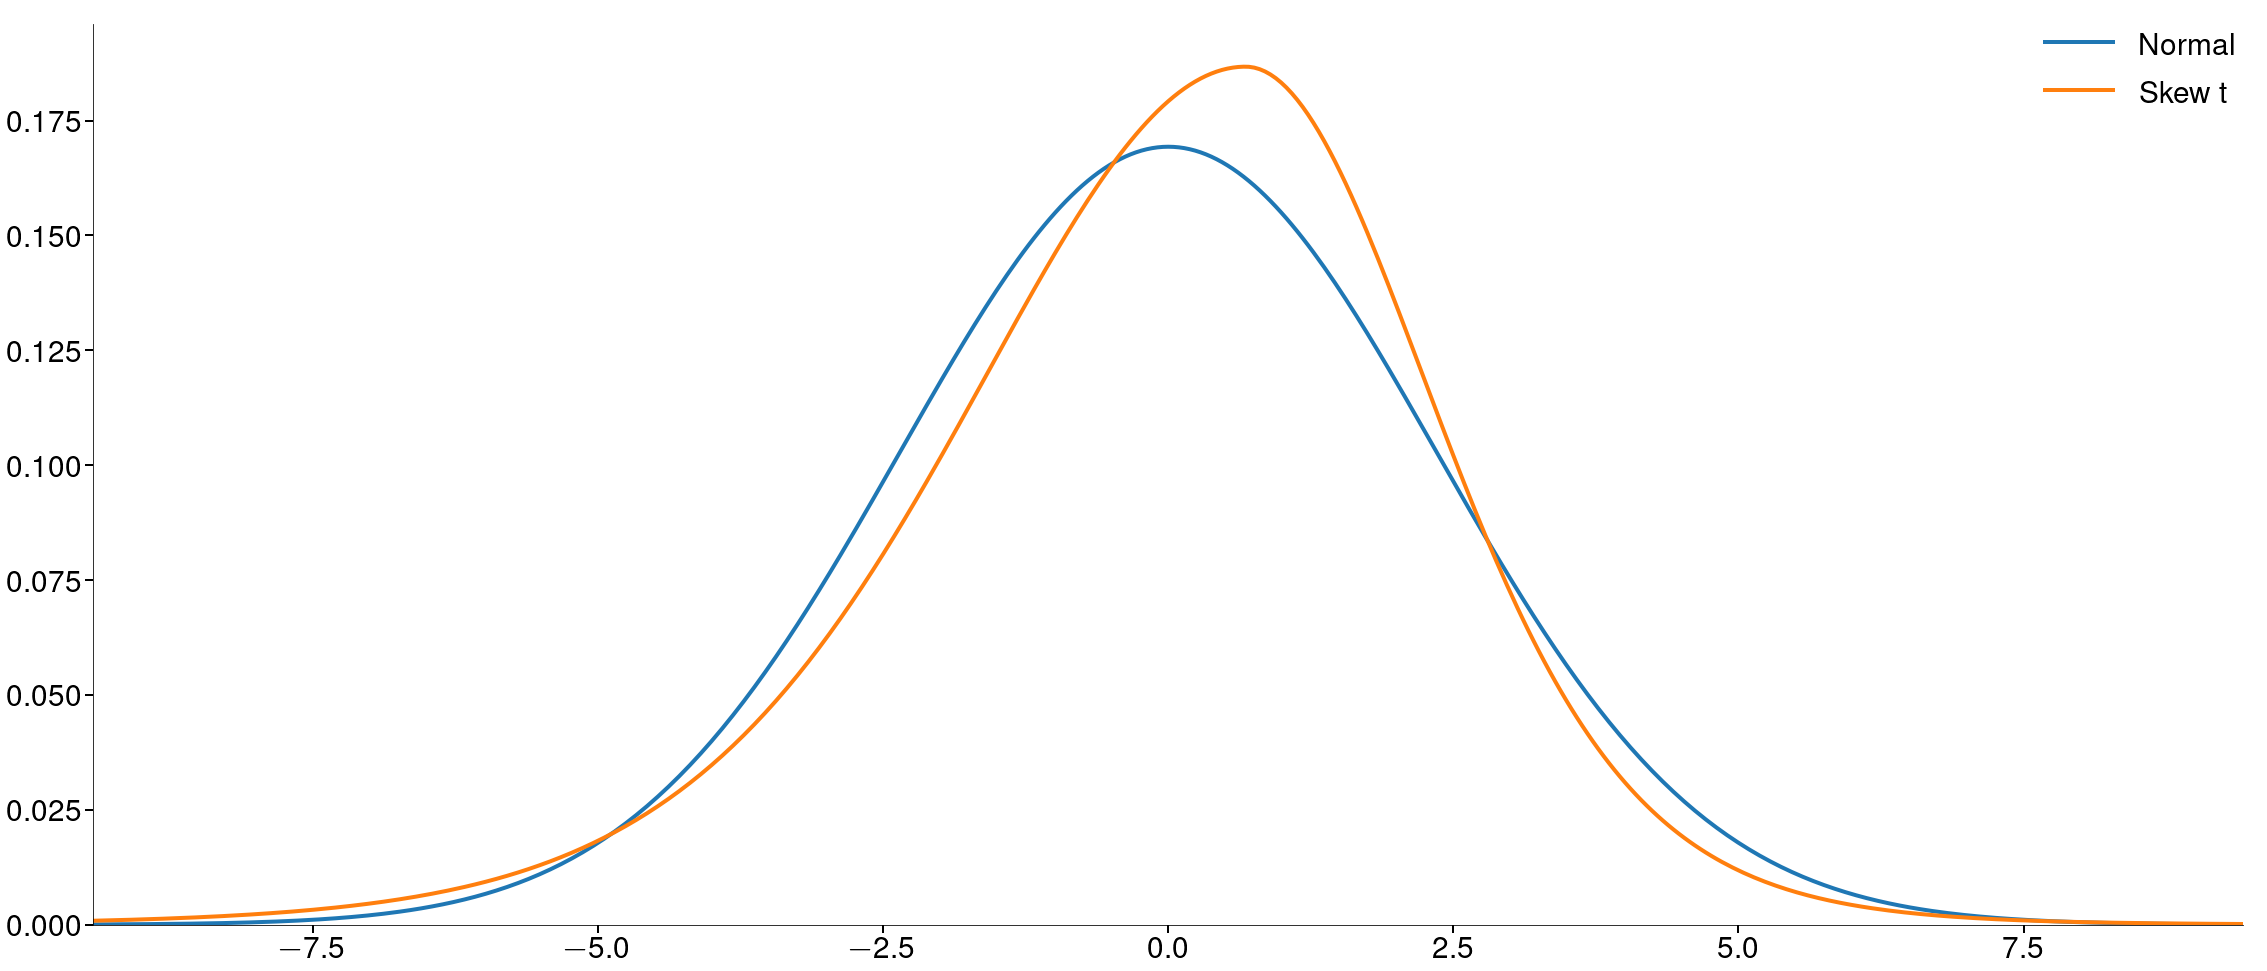

In [24]:
xl = density_plots()

# Kernel Densities

* _Smoothed_ densities are more precise than rough estimates

$$ g(e)=\frac{1}{Th}\sum_{t=1}^{T}K\left(\frac{\hat{e}_{t}-e}{h}\right),\,\,\,\,\hat{e}_{t}=\frac{y_{t}-\hat{\mu}_{t}}{\hat{\sigma}_{t}}=\frac{\hat{\epsilon}_{t}}{\hat{\sigma}_{t}} $$

* Local average of how many $\hat{e}_{t}$ there are in a small neighborhood of $e$
* $h$ is the bandwidth
  * Key parameter
  * Bias-variance trade-off

In [25]:
from statsmodels.nonparametric.kde import KDEUnivariate

kde = KDEUnivariate(tarch_normal.std_resid)
kde.fit()
bw = kde.bw
kde_over = KDEUnivariate(tarch_normal.std_resid)
kde_over.fit(bw=4 * bw)
kde_under = KDEUnivariate(tarch_normal.std_resid)
kde_under.fit(bw=bw / 4)
kde_df = pd.DataFrame(
    [kde.density / sigma, kde_over.density / sigma, kde_under.density / sigma],
    columns=sigma * kde.support,
    index=["Opt", "Over", "Under"],
).T


def kde_plot():
    plot(kde_df)
    ax = plt.gca()
    ax.set_ylim(0, ax.get_ylim()[-1])
    ax.set_xlim(xl)
    for l in ax.lines:
        l.set_linewidth(4)

# The effect of smoothing

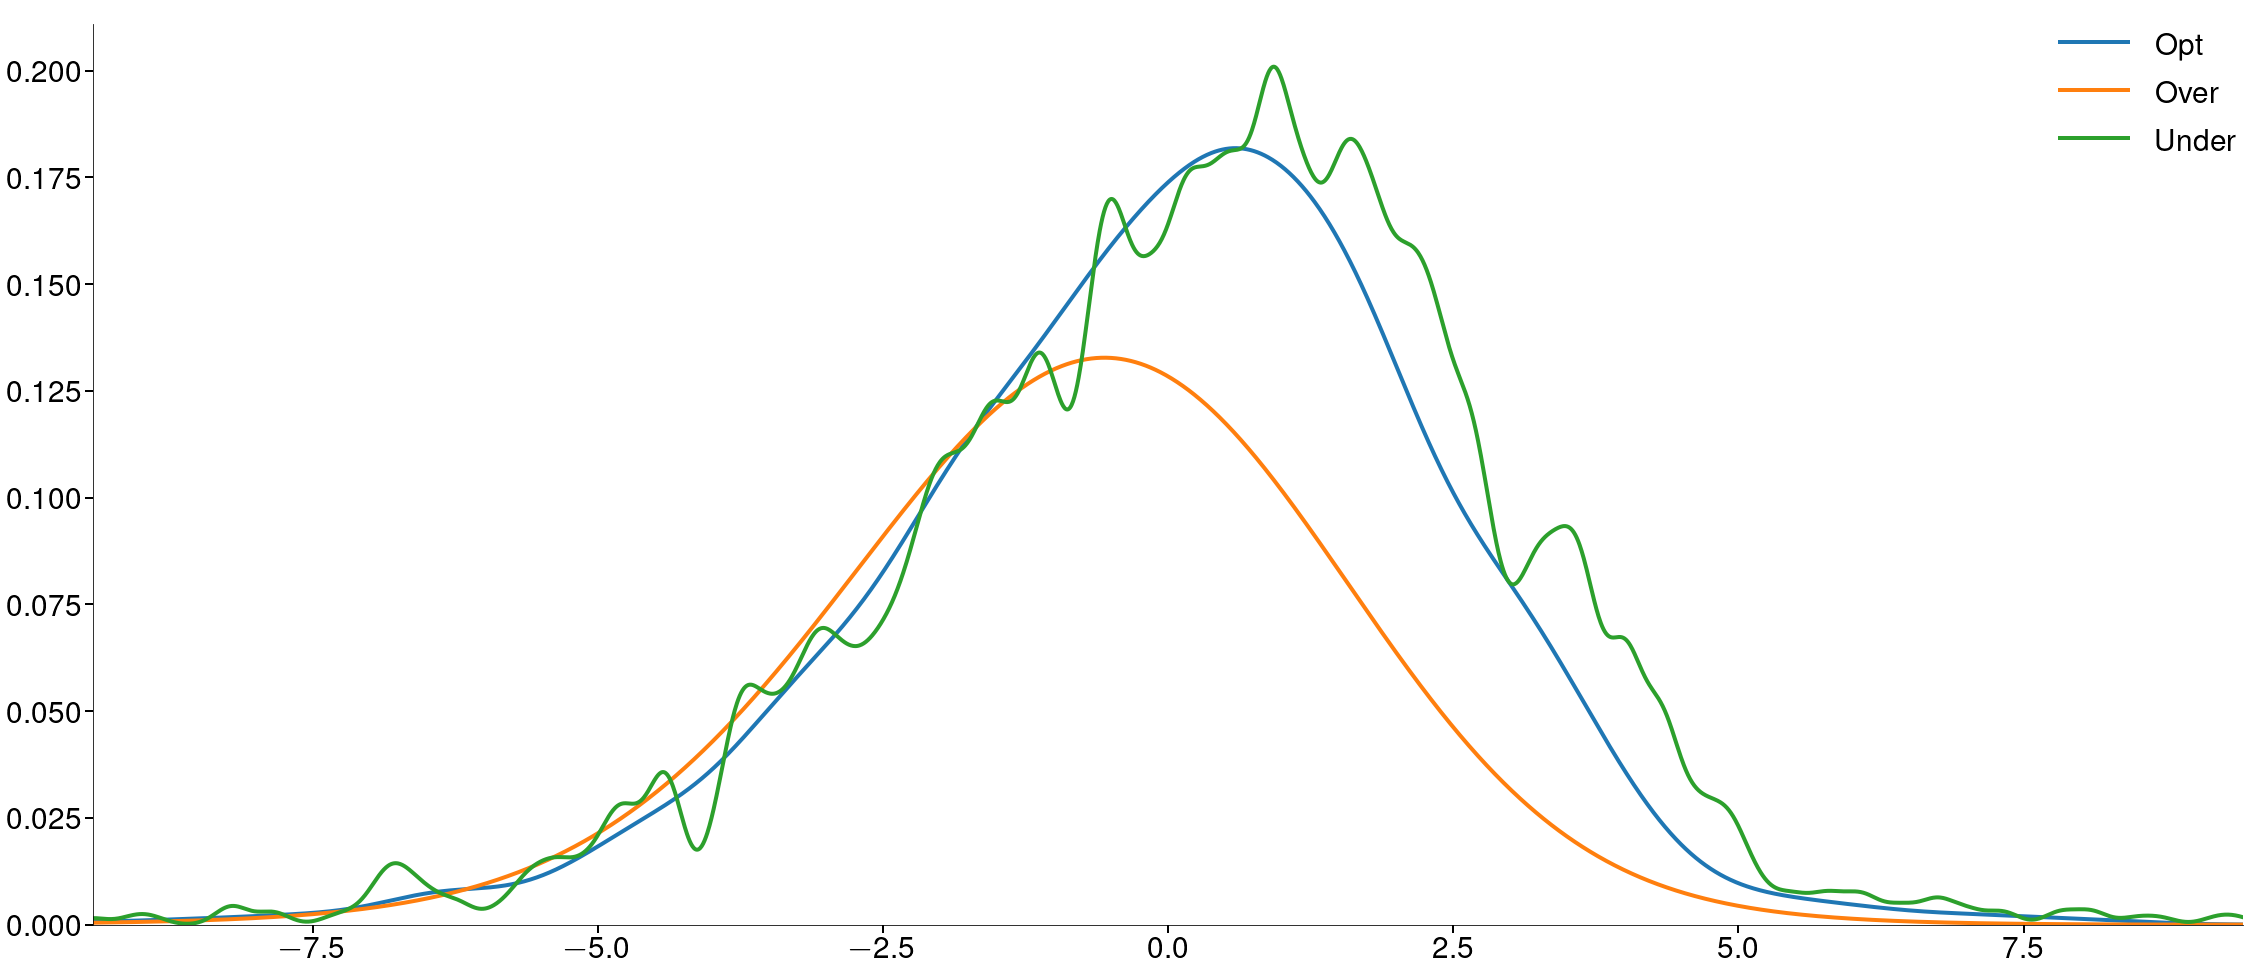

In [26]:
kde_plot()

In [27]:
def compare_densities():
    both = pd.concat([dens_df, kde_df["Opt"]], 1).sort_index()
    both.columns = list(both.columns[:2]) + ["KDE Optimal BW"]
    plot(both.interpolate().dropna())
    ax = plt.gca()
    ax.set_ylim(0, ax.get_ylim()[-1])
    ax.set_xlim(xl)
    for l in ax.lines:
        l.set_linewidth(4)

# Parametric vs KDE Densities

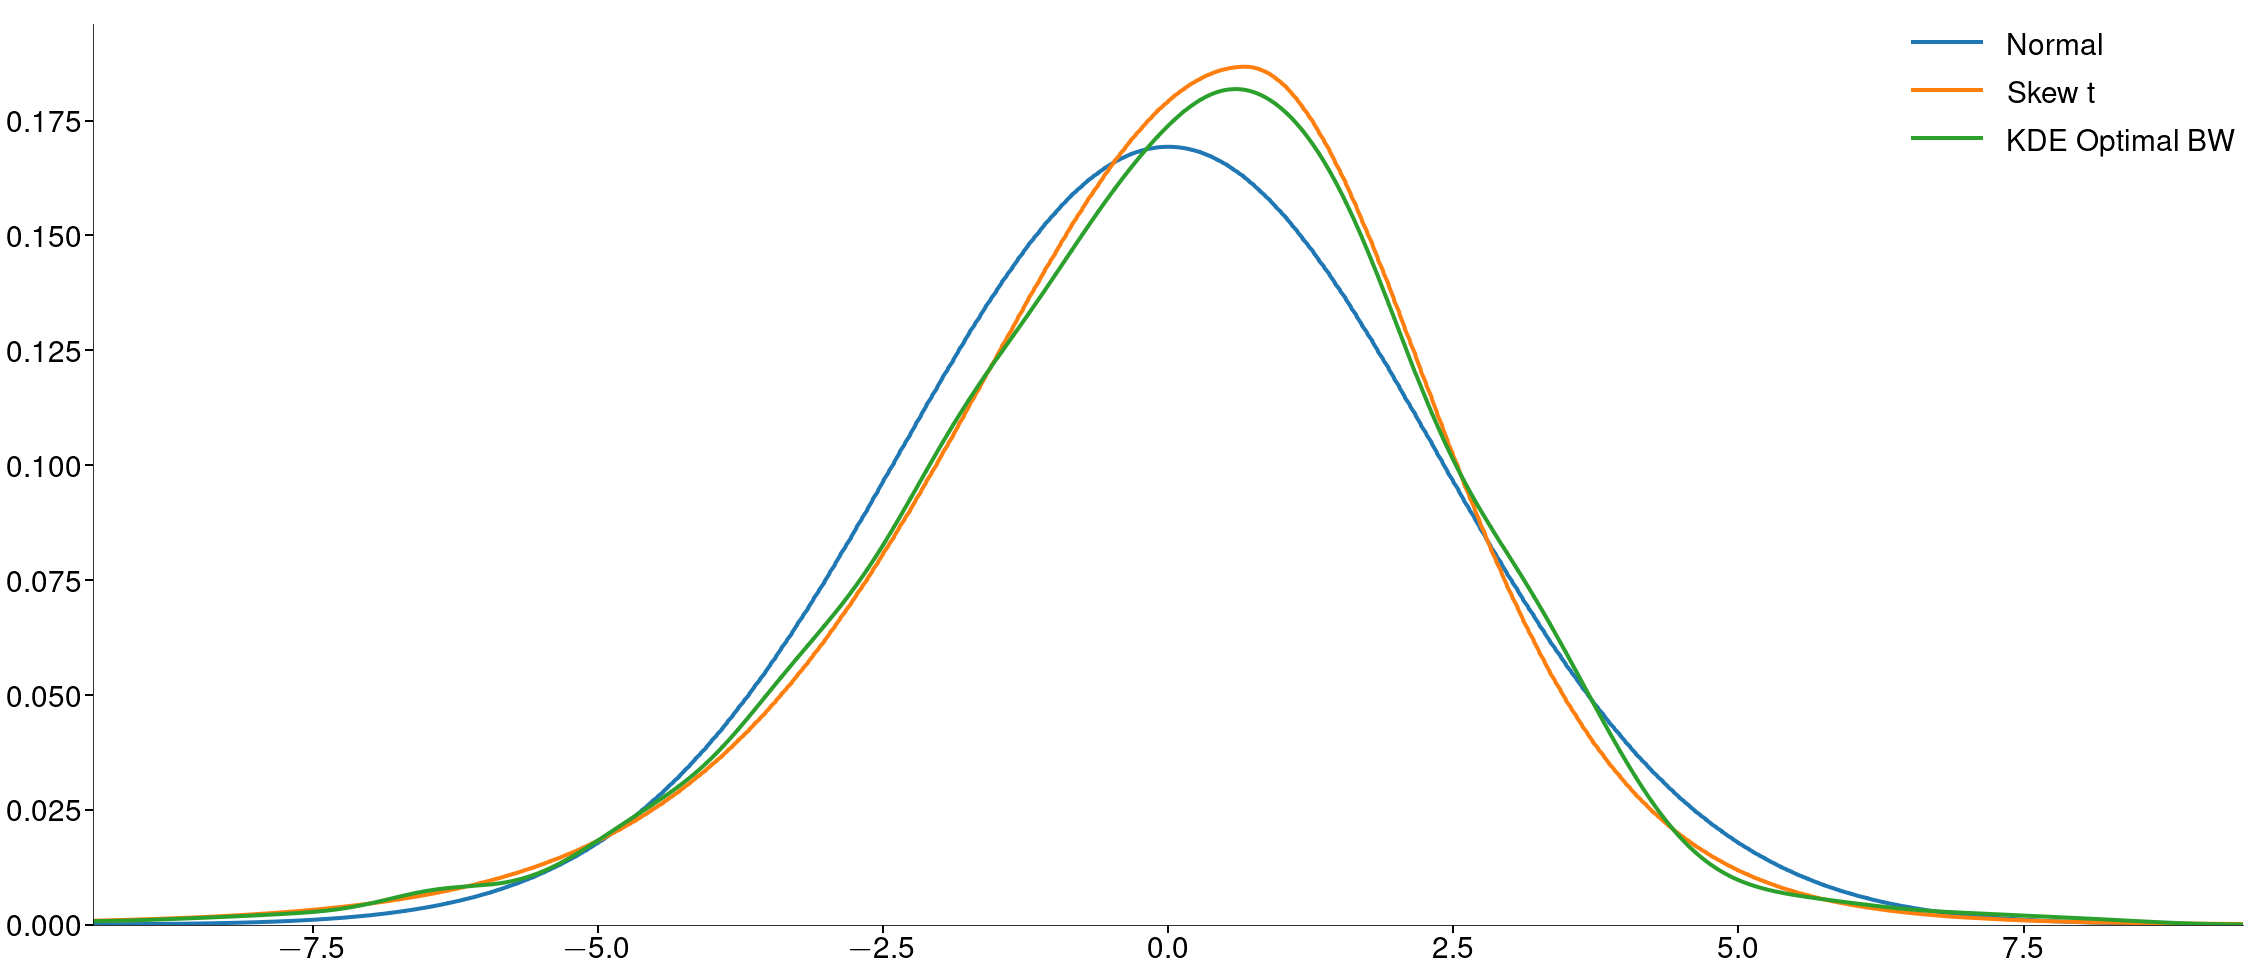

In [28]:
compare_densities()

# Kernel CDFs

In [29]:
def kernel_cdfs():
    df = pd.DataFrame(
        [kde.cdf, kde_over.cdf, kde_under.cdf],
        columns=sigma * kde.support,
        index=["Opt", "Over", "Under"],
    ).T
    plot(df)
    ax = plt.gca()
    ax.set_ylim(0, 1)
    ax.set_xlim(xl)
    for l in ax.lines:
        l.set_linewidth(4)

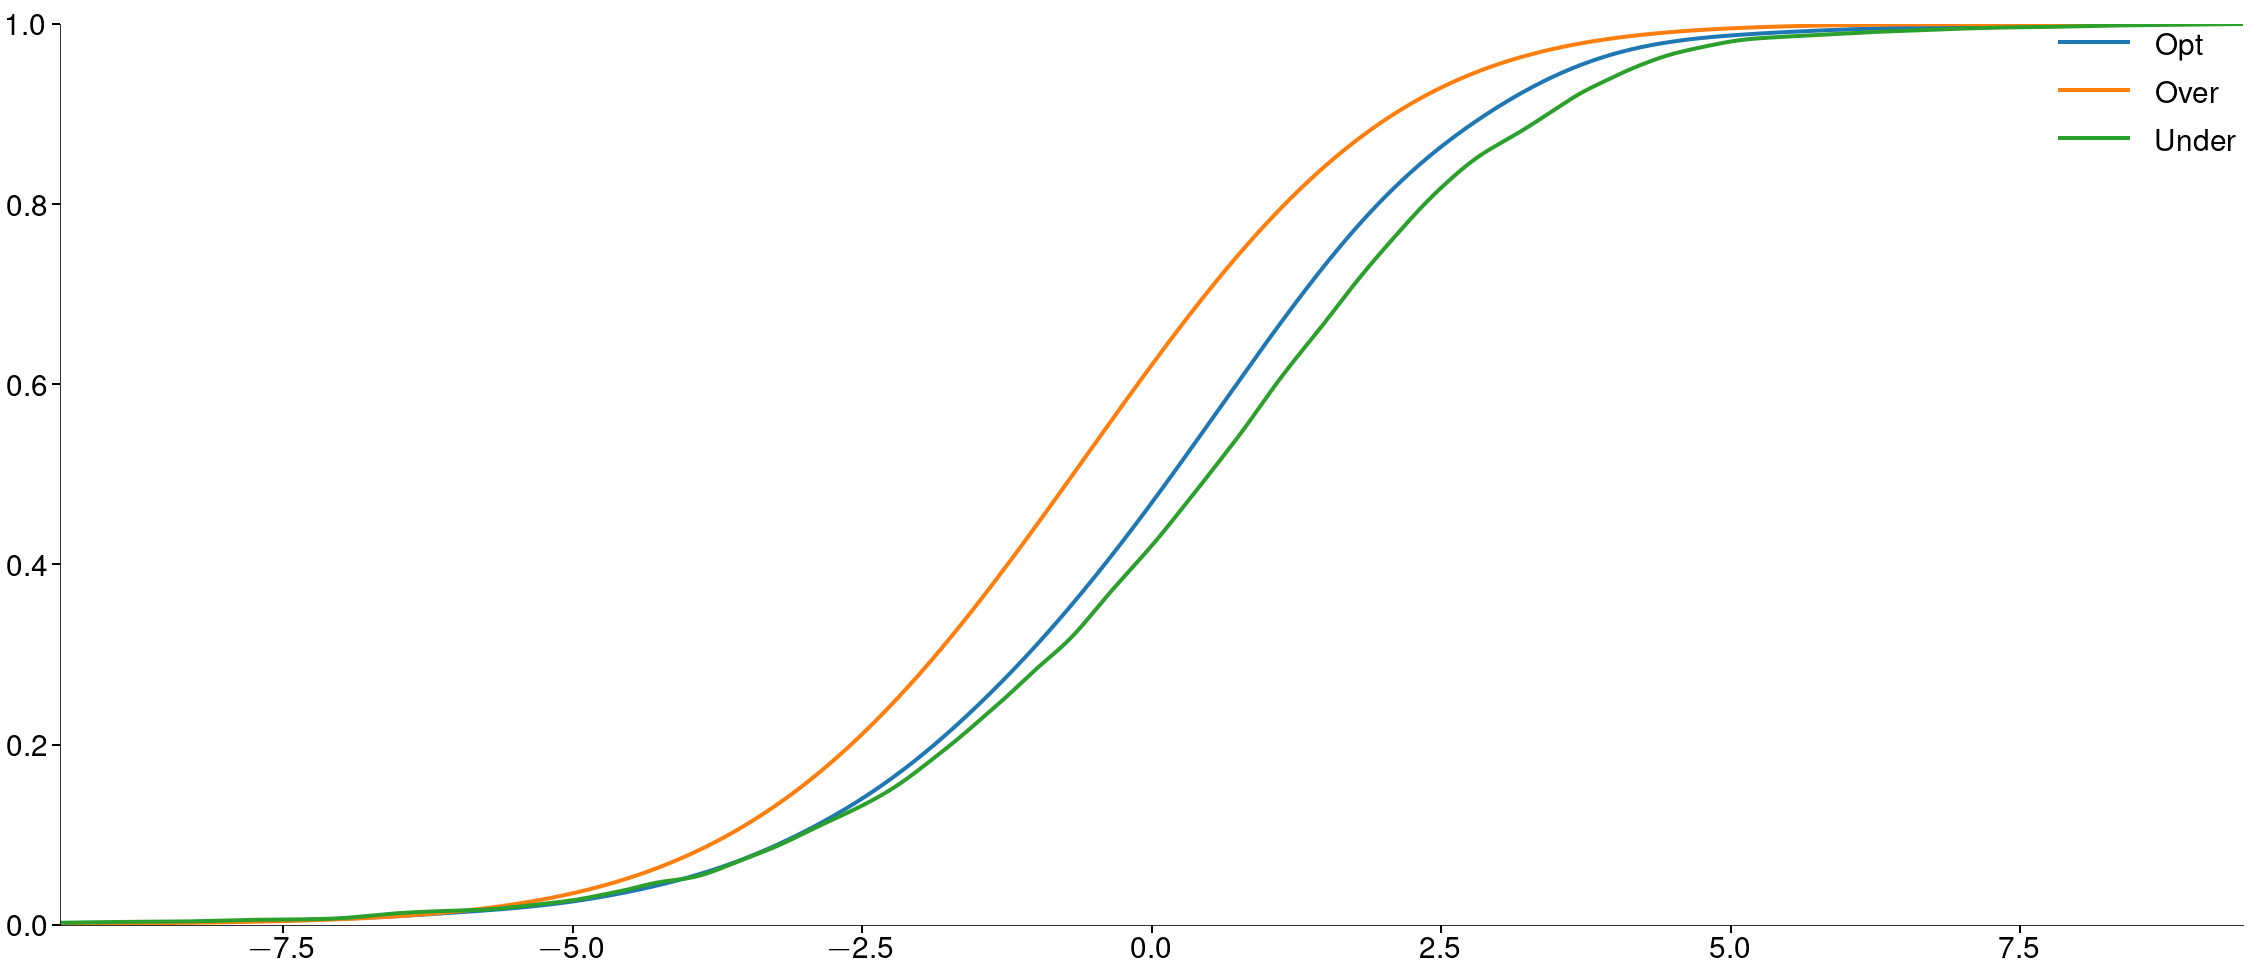

In [30]:
kernel_cdfs()

# Multi-step Density Forecasting

* Densities do not aggregate
* Analytical forecasts are challenging
* Simple solution: simulate

# Simulation-based Forecasting

* Condition on final observation
* Simulate using either:
  * Assumed distribution
  * IID Bootstrap of standardized residuals

In [31]:
skew_t_fcast = tarch_skewt.forecast(
    horizon=12, simulations=5000, method="simulation", reindex=False
)
normal_fcast = tarch_normal.forecast(
    horizon=12, simulations=5000, method="simulation", reindex=False
)
bootstrap_fcast = tarch_normal.forecast(
    horizon=12, simulations=5000, method="bootstrap", reindex=False
)

In [32]:
yl = {"yl": None}


def plot_sim(forecasts):
    r = 1 + forecasts.simulations.values[-1].T / 100.0
    cr = 100 * np.cumprod(r, 0) - 100
    x = np.arange(1, cr.shape[0] + 1)
    _ = plt.plot(
        x,
        cr,
        color=mfe.colors[0],
        alpha=0.1,
        marker=".",
        linestyle="none",
        markersize=24,
    )
    ax = plt.gca()
    if yl["yl"] is None:
        yl["yl"] = ax.get_ylim()
    else:
        ax.set_ylim(yl["yl"])
    ax.set_xticks(x)

# Normal Simulated Values

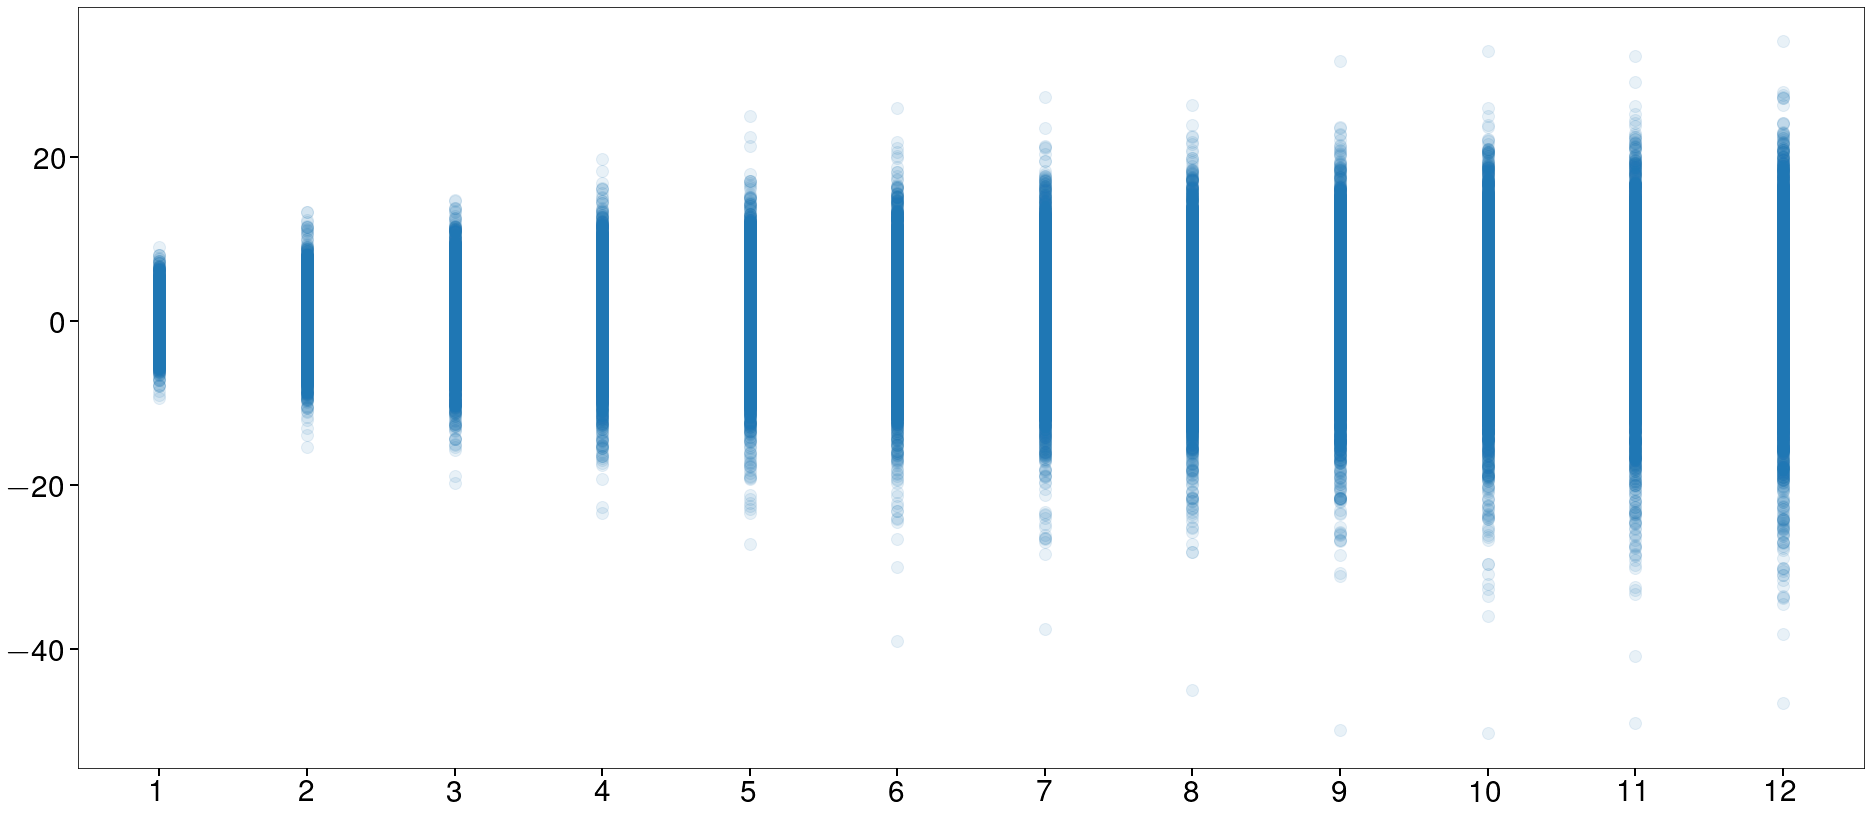

In [33]:
plot_sim(normal_fcast)

# Skew $t$ Simulated Values

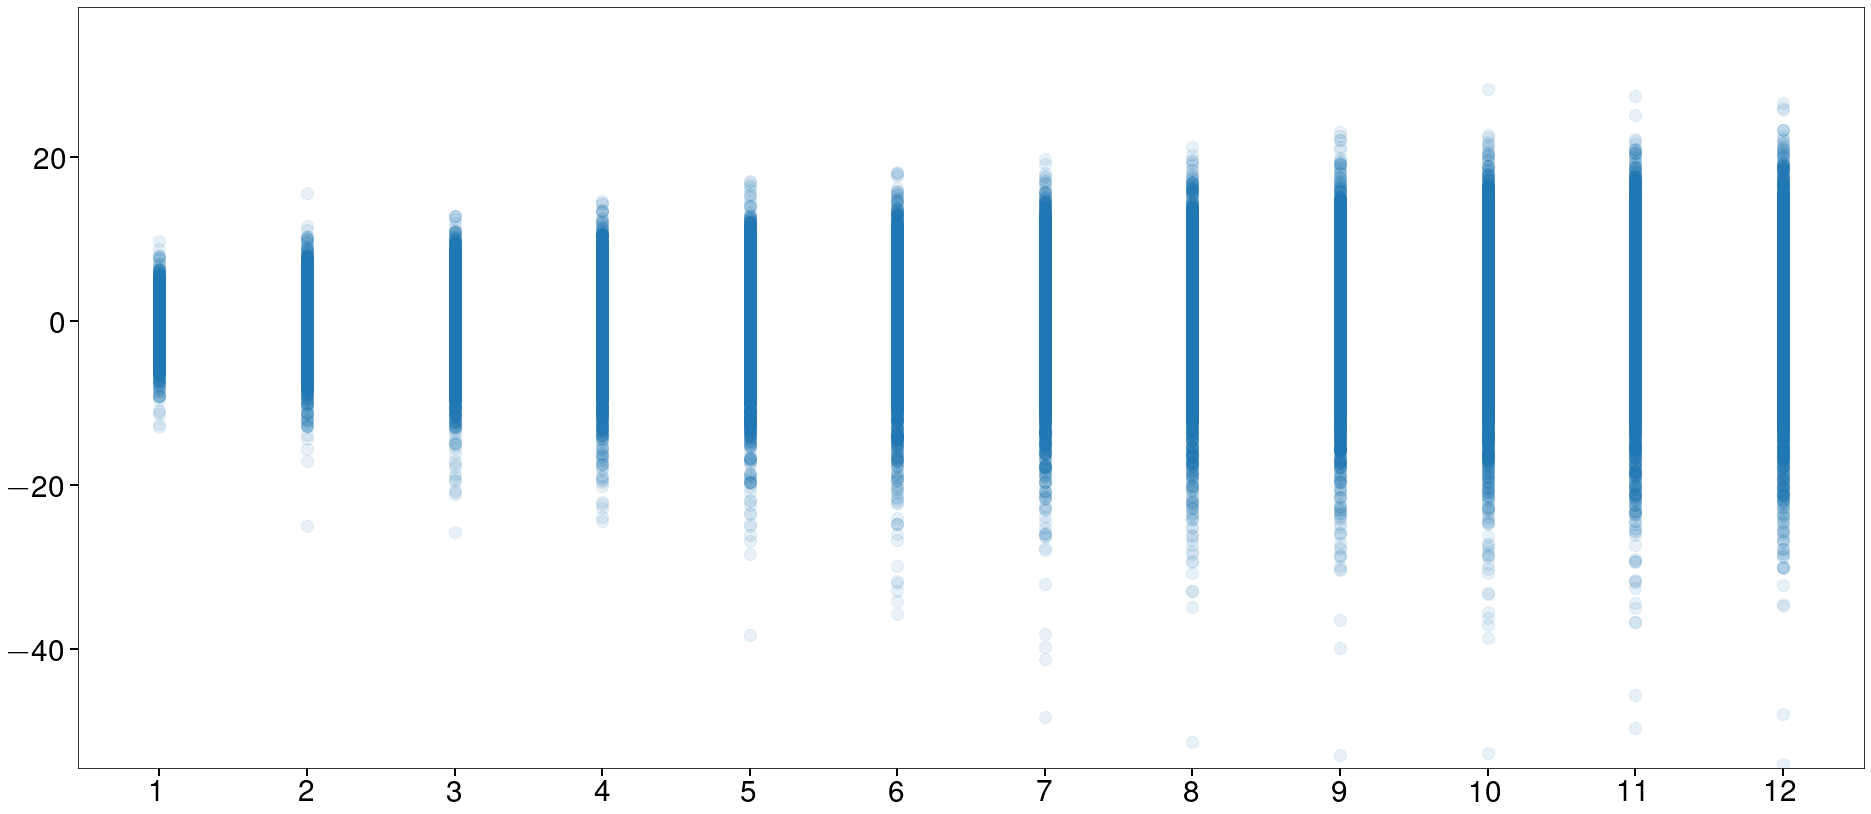

In [34]:
plot_sim(skew_t_fcast)

# Bootstrap Simulated Values

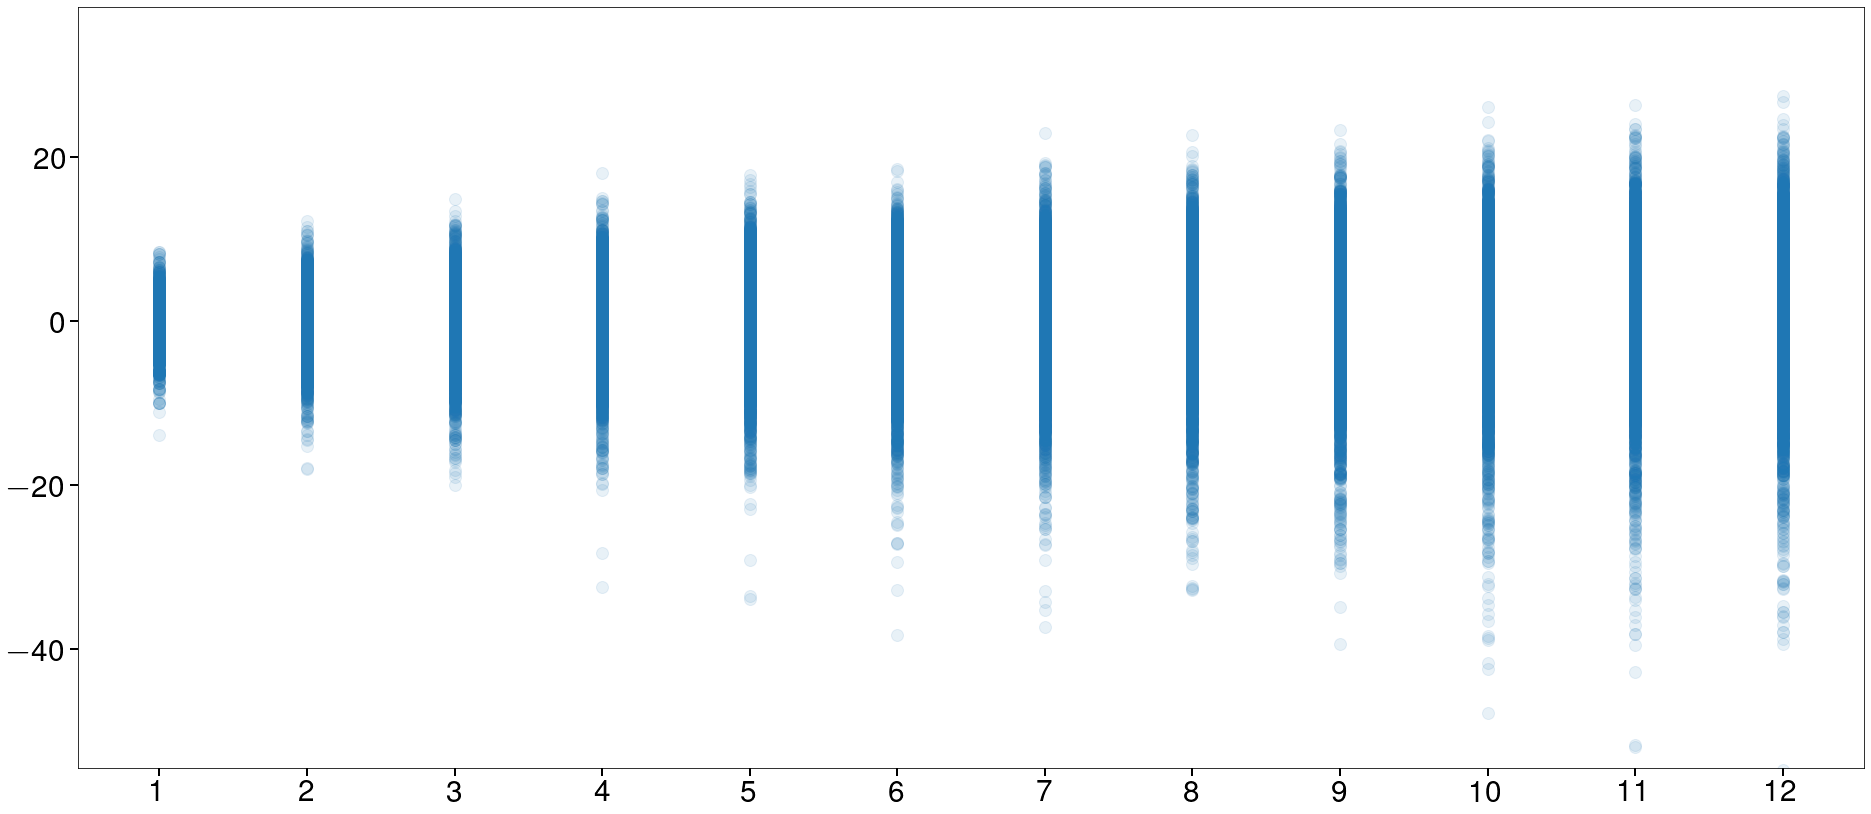

In [35]:
plot_sim(bootstrap_fcast)

# Quantile Plot

* Plot quantiles across horizon
* Simplification of fan plot

In [36]:
yl = {"yl": None}


def plot_quantile(forecasts):
    r = 1 + forecasts.simulations.values[-1].T / 100.0
    cr = 100 * np.cumprod(r, 0) - 100
    q = pd.DataFrame(cr.T).quantile([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
    q.index = [f"{100*i}%" for i in q.index]
    q.columns = np.arange(1, q.shape[1] + 1)
    q = q.T
    fig, ax = plt.subplots(
        1, 1, figsize=(mfe.DEFAULT_FIGSIZE[0], mfe.DEFAULT_FIGSIZE[1] - 1)
    )
    ax.plot(q.index, q, linewidth=4)
    ax.set_xlim(1, 12)
    ax.set_xticks(np.arange(1, 13))
    sns.despine()
    fig.tight_layout(pad=1.0)
    markers = [":", "-.", "--", "-", "-"]
    for i, l in enumerate(ax.lines):
        if i < 5:
            l.set_linestyle(markers[i])
            l.set_color(mfe.colors[i])
            l.set_label(q.columns[i])
        else:
            l.set_linestyle(markers[8 - i])
            l.set_color(mfe.colors[8 - i])
    plt.legend(ncol=5, frameon=False)
    if yl["yl"] is None:
        scale = 1.1
        _yl = ax.get_ylim()
        _yl = np.abs(_yl)
        _yl = (-scale * _yl.max(), scale * _yl.max())
        yl["yl"] = _yl
    ax.set_ylim(yl["yl"])

# Normal

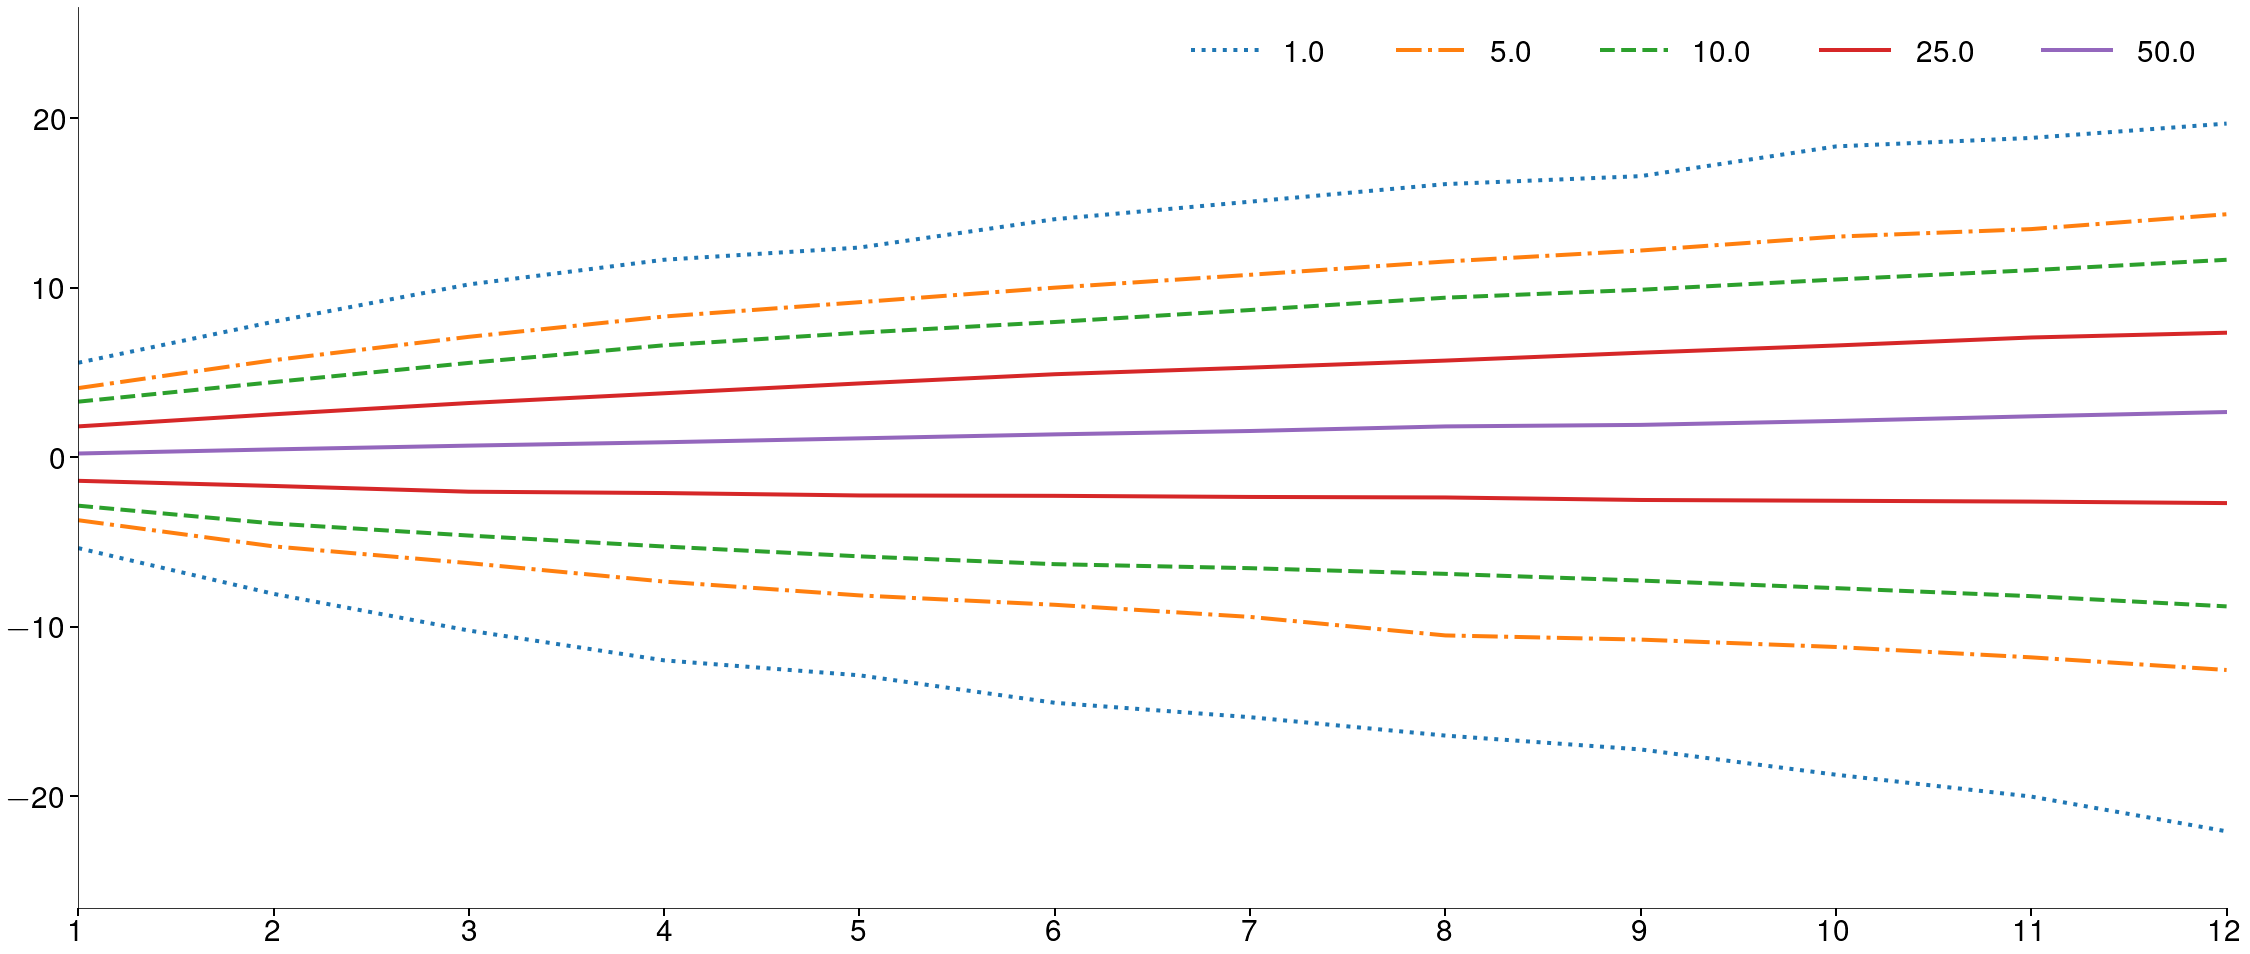

In [37]:
plot_quantile(normal_fcast)

# Skew $t$

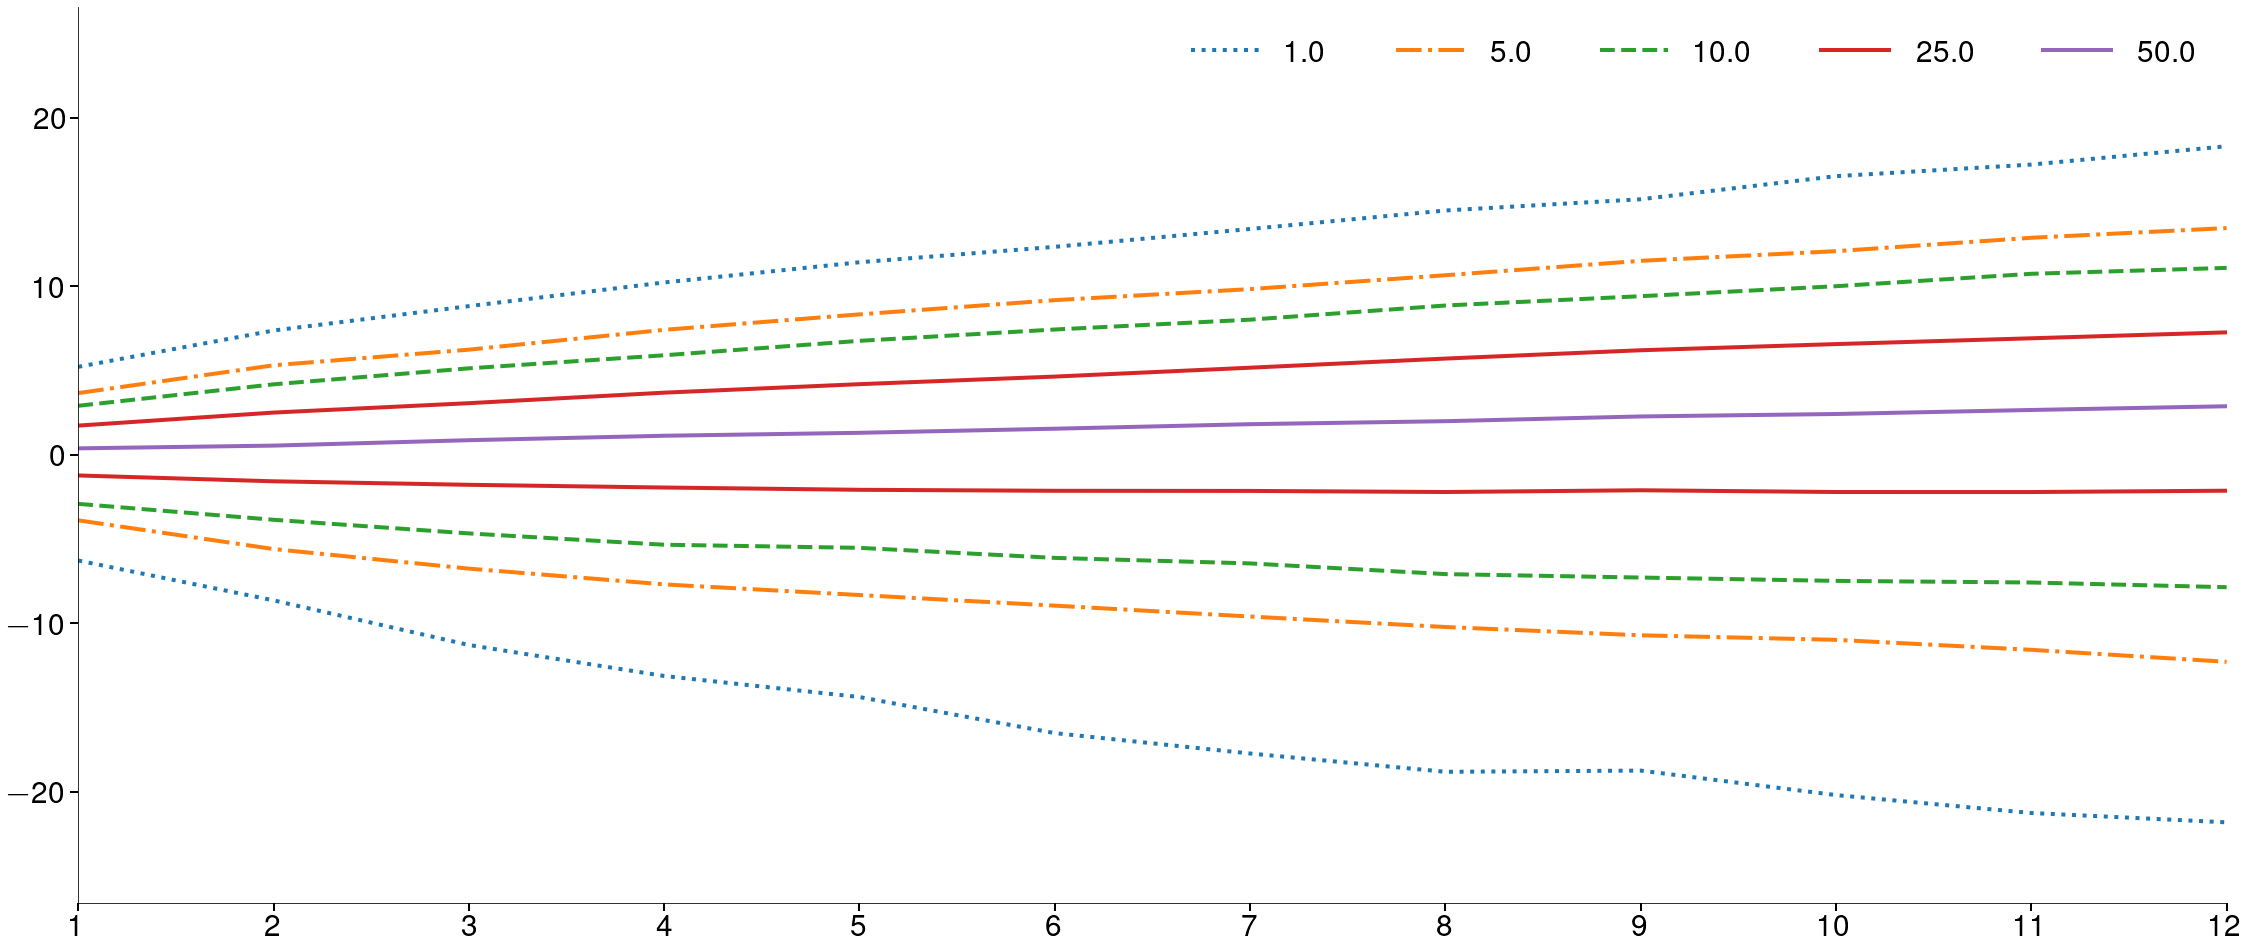

In [38]:
plot_quantile(skew_t_fcast)

# Bootstrap

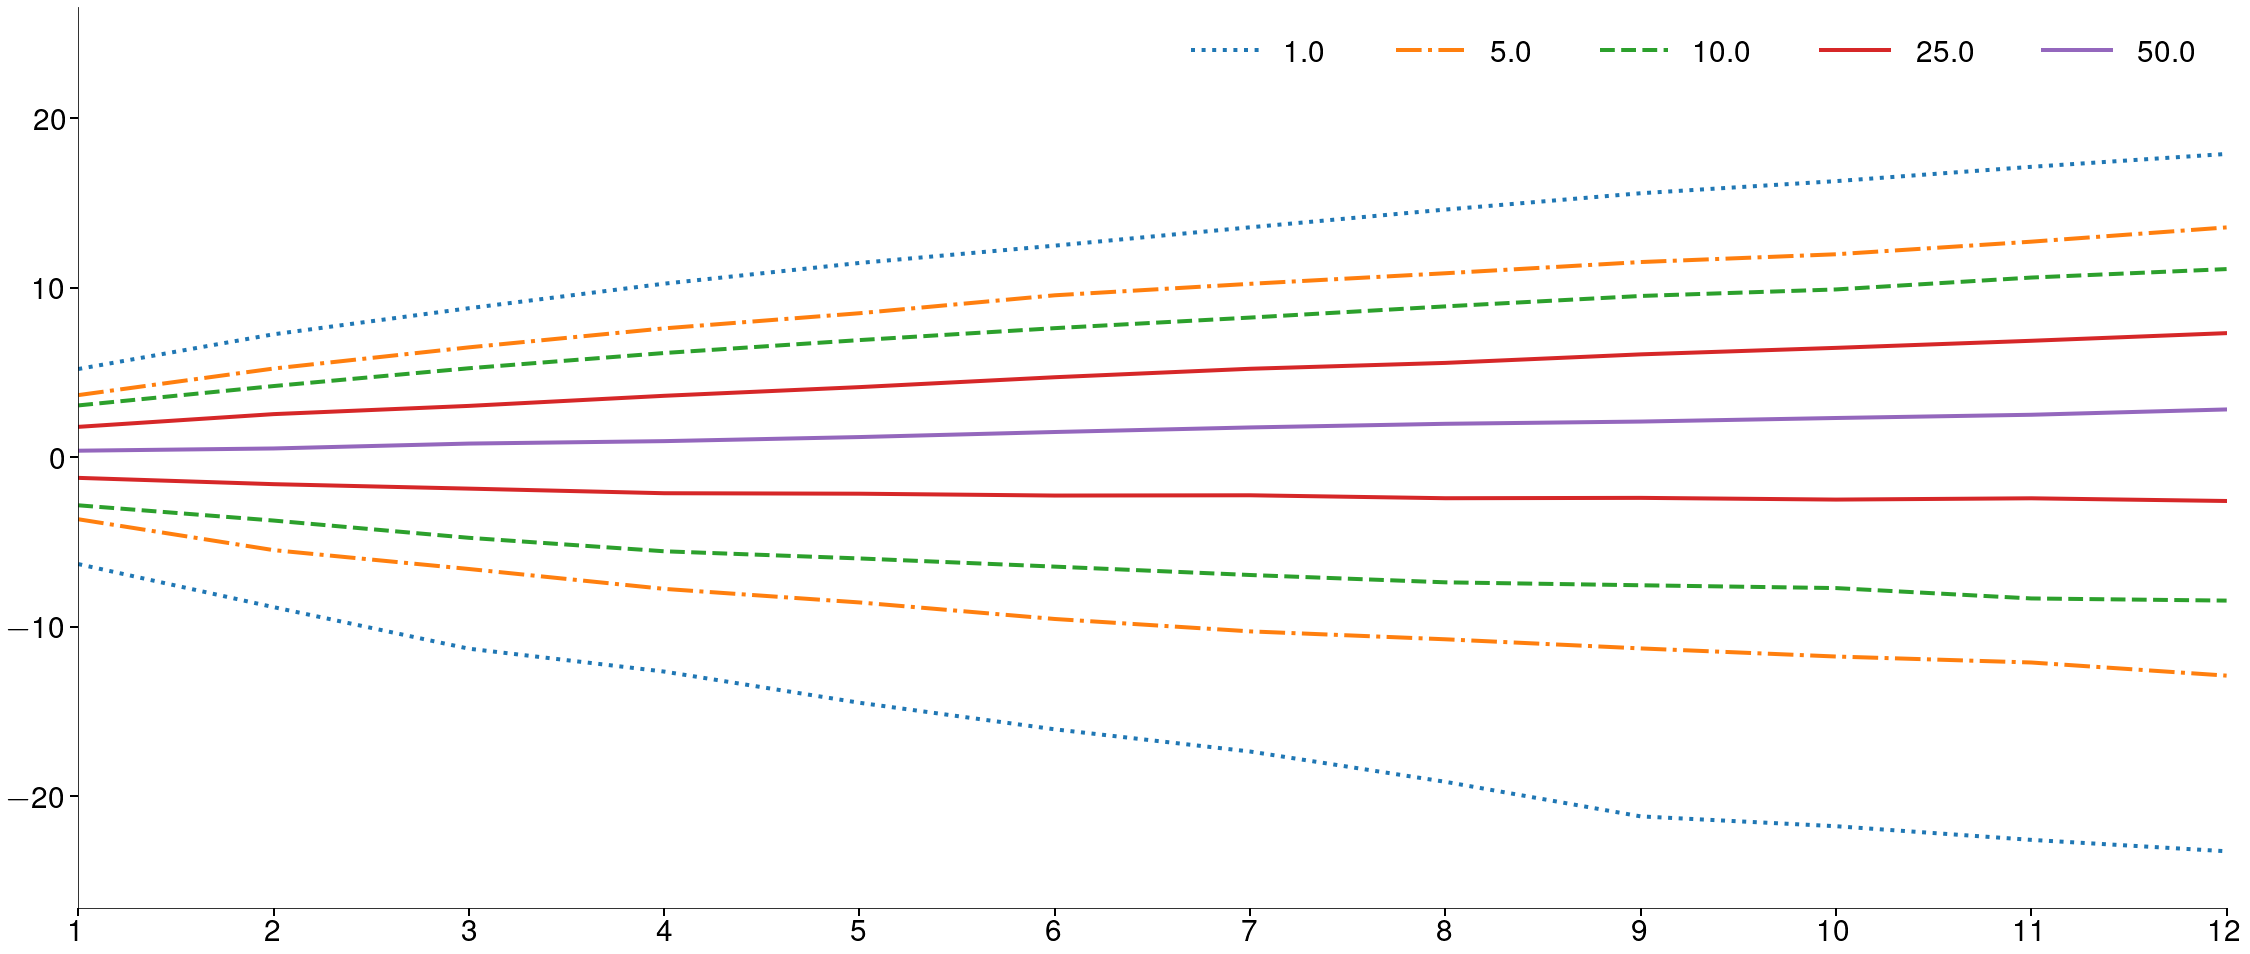

In [39]:
plot_quantile(bootstrap_fcast)

# Quantile-Quantile (QQ) Plots 


* Plots the data against a hypothetical distribution

$$\hat{e}_{1}<\hat{e}_{2}<\ldots<\hat{e}_{N-1}<\hat{e}_{N} $$

* $N=T$ but used to indicate that the index is not related to time 

* $e_{n}$ against $F^{-1}\left(\frac{j}{T+1}\right)$

$$F^{-1}\left(\frac{1}{T+1}\right)<F^{-1}\left(\frac{2}{T+1}\right)<\ldots<F^{-1}\left(\frac{T-1}{T+1}\right)<F^{-1}\left(\frac{T}{T+1}\right) $$

* $F^{-1}$ is inverse cdf of distribution being used for comparison 

# Normal

In [40]:
def qq_normal():
    n = sp500_weekly.shape[0]
    expected_pit = np.arange(1, n + 1) / (n + 1)
    expected = tarch_normal.model.distribution.ppf(expected_pit, [])
    df = pd.DataFrame(tarch_skewt.std_resid.sort_values())
    df.index = index = expected
    df.columns = ["Weekly S\&P 500 Std. Resid"]
    plot(df, loc=5)
    ax = plt.gca()
    ax.lines[0].set_marker("o")
    ax.lines[0].set_linestyle("none")
    rng = np.array([ax.get_xlim(), ax.get_ylim()])
    bnds = (rng[:, 0].min(), rng[:, 1].max())
    ax.plot(bnds, bnds, linewidth=4, zorder=-3, color=mfe.colors[7])
    ax.set_xlim(bnds)
    ax.set_ylim(bnds)

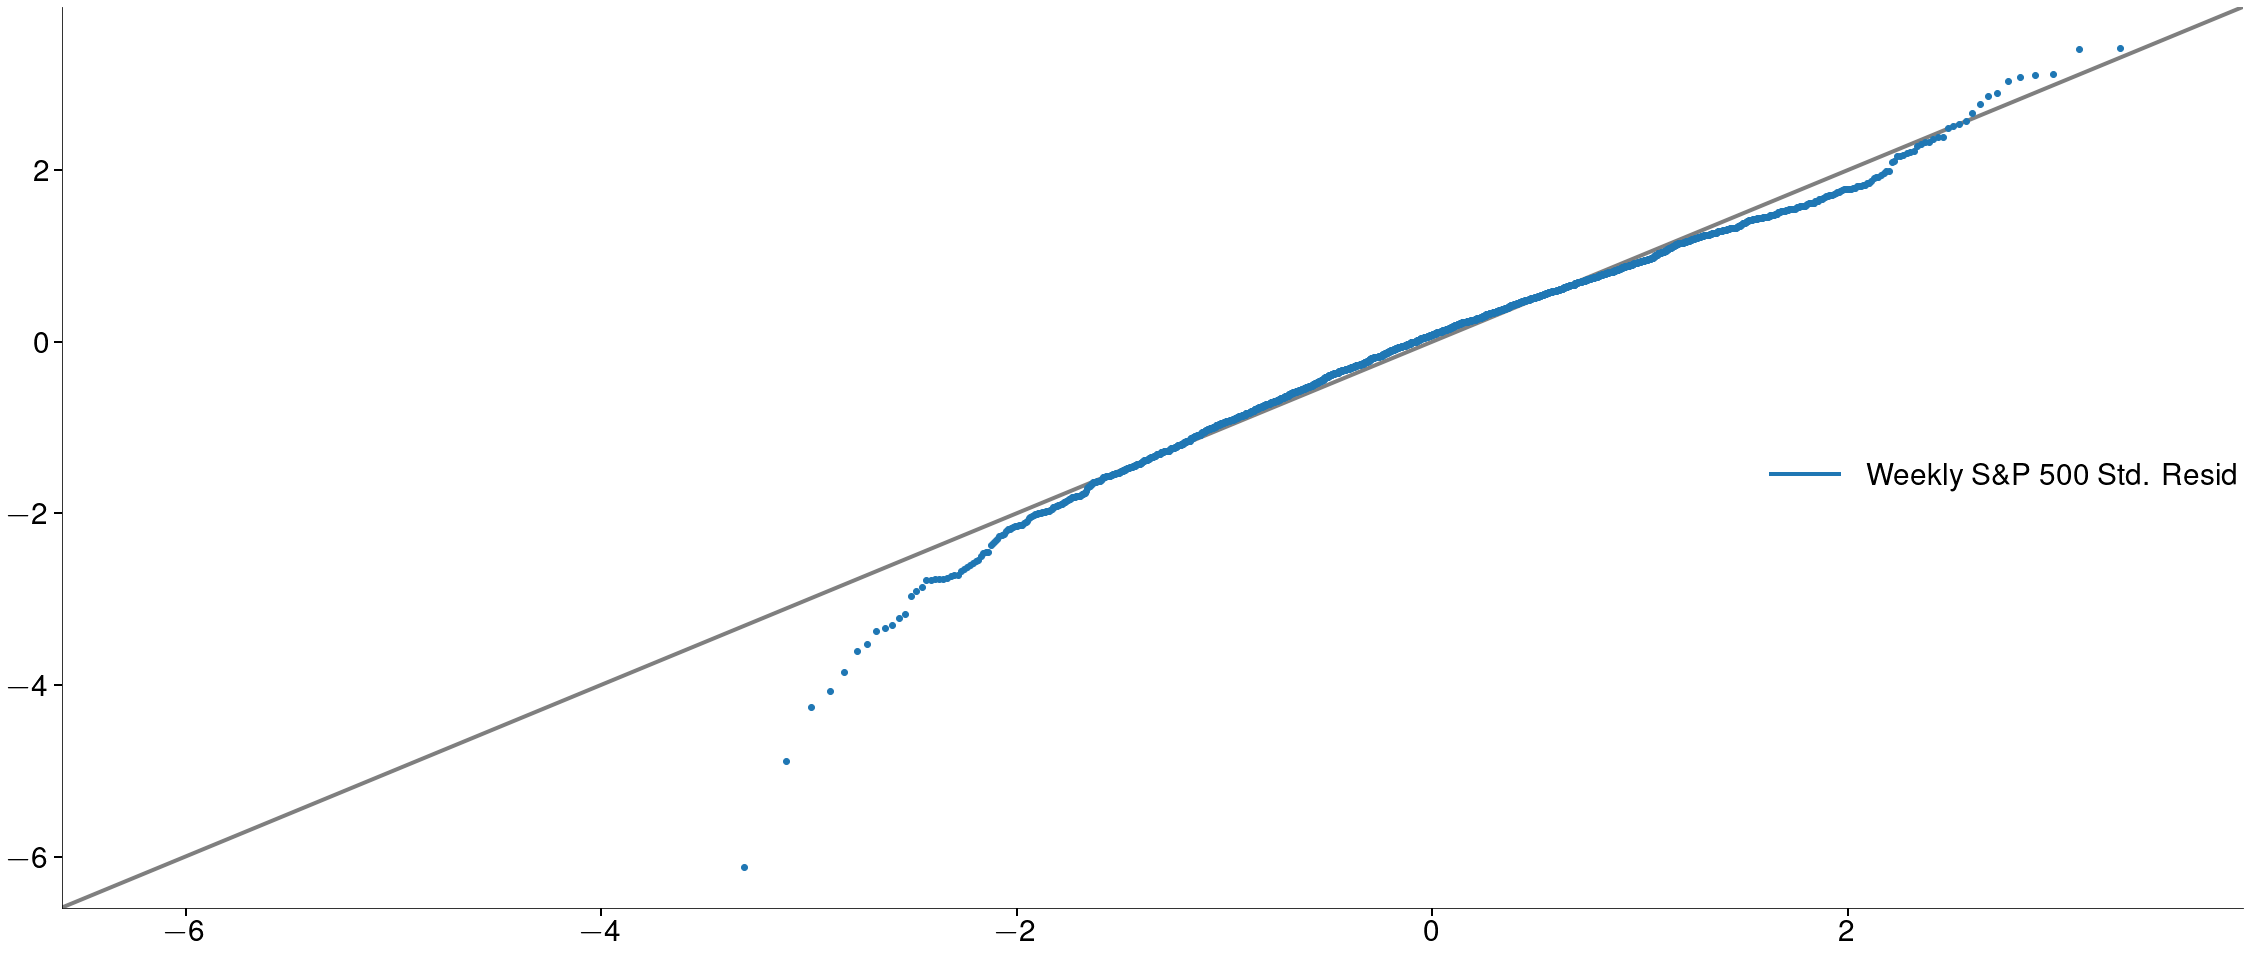

In [41]:
qq_normal()

# Skew $t$

In [42]:
def qq_skewt():
    n = sp500_weekly.shape[0]
    expected_pit = np.arange(1, n + 1) / (n + 1)
    expected = tarch_skewt.model.distribution.ppf(
        expected_pit, tarch_skewt.params.iloc[-2:]
    )
    df = pd.DataFrame(tarch_skewt.std_resid.sort_values())
    df.index = index = expected
    df.columns = ["Weekly S\&P 500 Std. Resid"]
    plot(df, loc=5)
    ax = plt.gca()
    ax.lines[0].set_marker("o")
    ax.lines[0].set_linestyle("none")
    rng = np.array([ax.get_xlim(), ax.get_ylim()])
    bnds = (rng[:, 0].min(), rng[:, 1].max())
    ax.plot(bnds, bnds, linewidth=4, zorder=-3, color=mfe.colors[7])
    ax.set_xlim(bnds)
    ax.set_ylim(bnds)

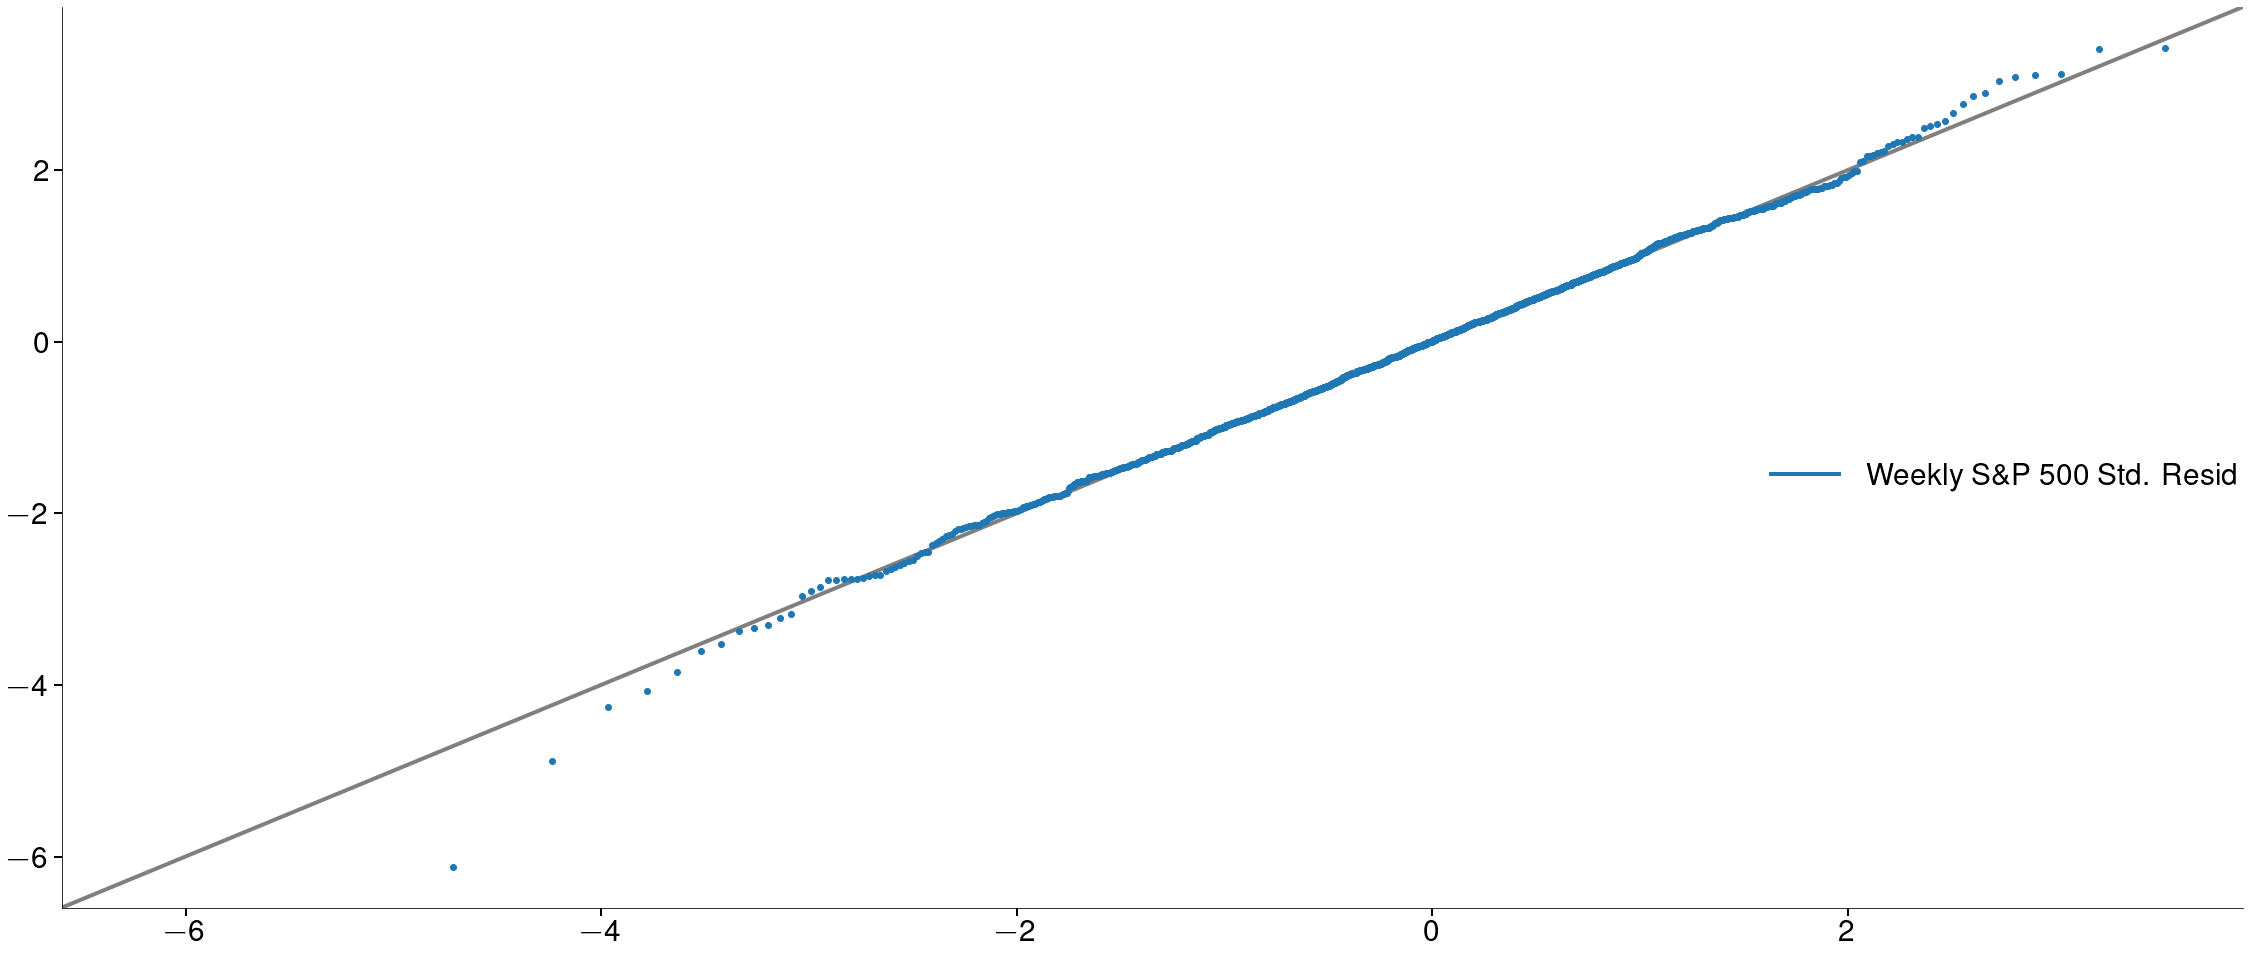

In [43]:
qq_skewt()

# Kolmogorov-Smirnov Tests

* Formalizes QQ plots 
* Key property 
  * If $x\sim F$, then $u\equiv F(x)\sim U(0,1)$
  * Test of $U(0,1) $
* KS tests maximum deviation from U(0,1) 

$$\max_{\tau}\left|\frac{1}{T}\left(\sum_{i=1}^{\tau}I_{[u_{i}<\frac{\tau}{T}]}\right)-\frac{\tau}{T}\right|,\quad\tau=1,2,\ldots,T $$

* $\frac{1}{T}\sum_{i=1}^{\tau}I_{[u_{j}<\frac{\tau}{T}]}$ - empirical percentage of $u$ below $\tau/T$
* $\tau/T$ - expected fraction below $\tau/T$

# Normal

In [44]:
u = tarch_normal.model.distribution.cdf(tarch_normal.std_resid)
u

array([0.93070668, 0.67285647, 0.88197524, ..., 0.82719633, 0.02590035,
       0.87017271])

In [45]:
def ksplot(u):
    sorted_u = np.sort(u)
    x = np.arange(u.shape[0], dtype=float) / u.shape[0]
    plt.plot(
        x, sorted_u, color=mfe.colors[1], linestyle="none", marker=".", markersize=12
    )
    plt.plot(x, x, "k--", zorder=-3)
    ax = plt.gca()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    _ = ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1])

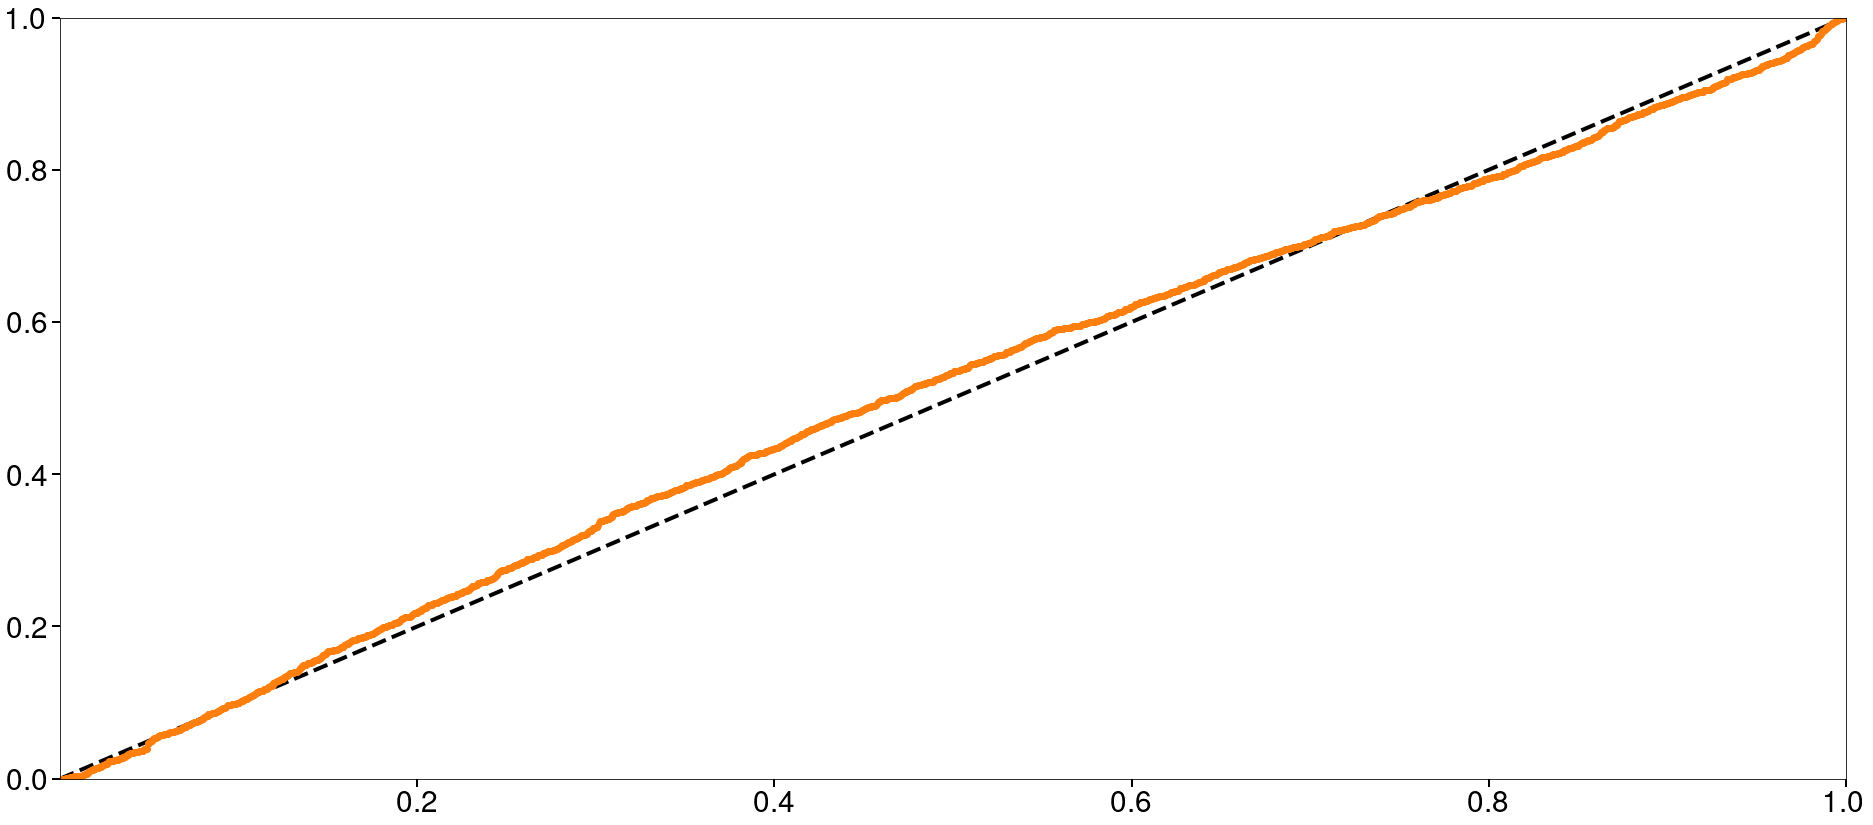

In [46]:
ksplot(u)

In [47]:
e = tarch_skewt.std_resid
params = tarch_skewt.params
u = tarch_skewt.model.distribution.cdf(e, params.iloc[-2:])
u

array([0.94884121, 0.66601544, 0.90364638, ..., 0.84502048, 0.03494379,
       0.89527678])

# Skew $t$

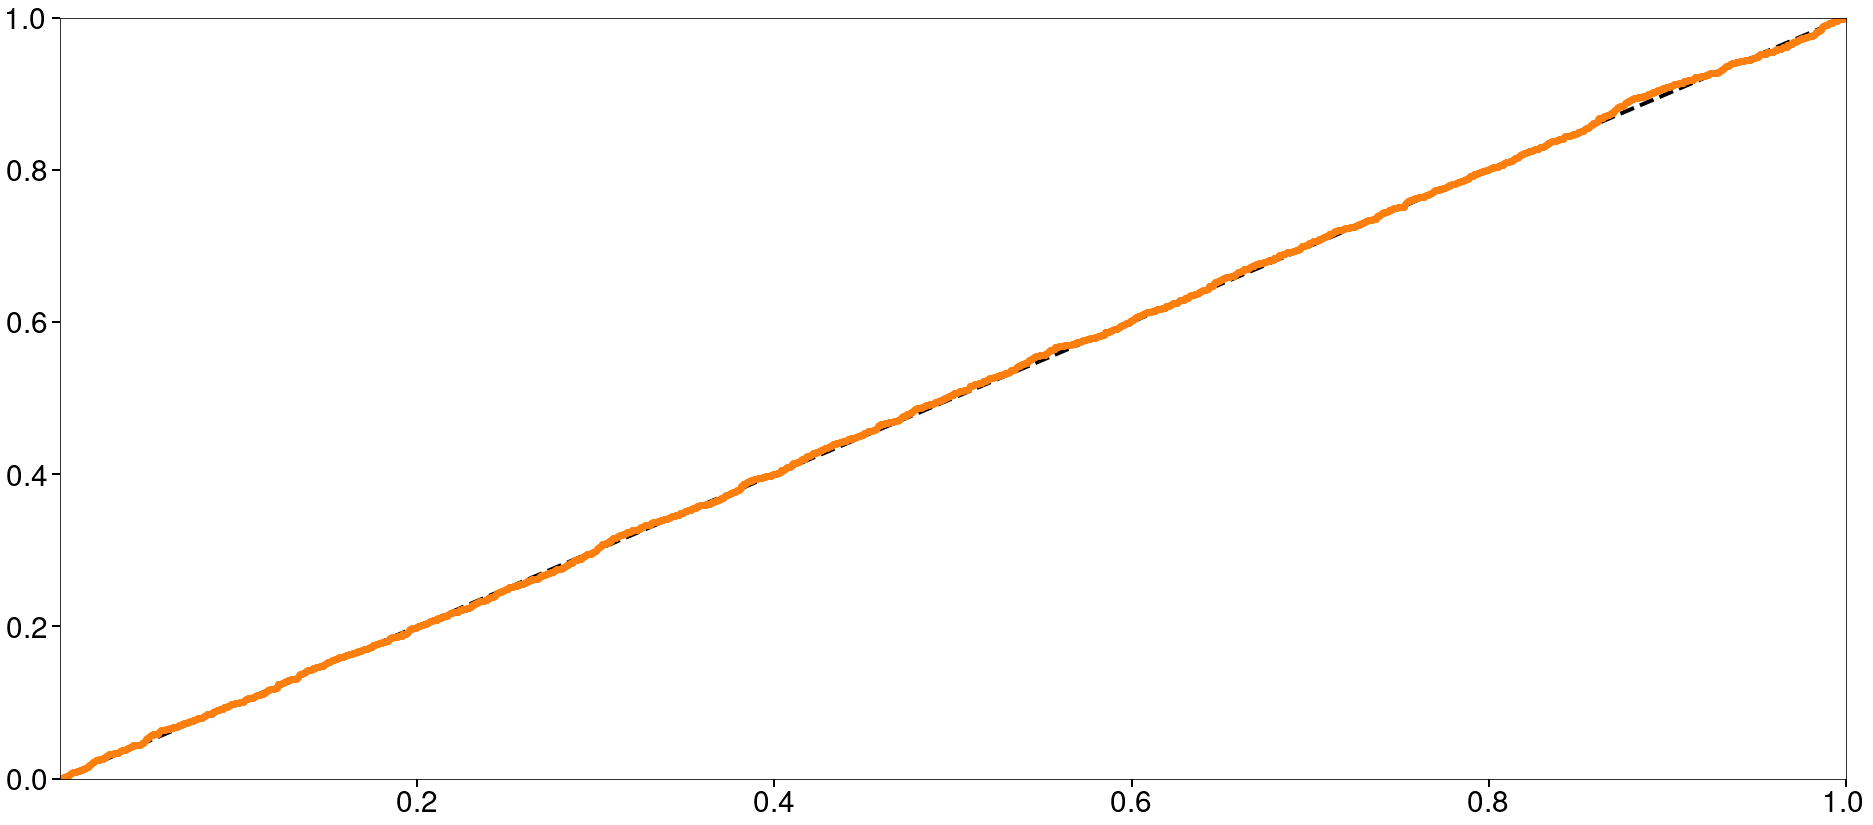

In [48]:
ksplot(u)

# Kolmogorov-Smirnov Tests

In [49]:
from scipy.stats import kstest
from statsmodels.stats.diagnostic import kstest_fit
e = tarch_skewt.std_resid
params = tarch_skewt.params
skew_t_dist = tarch_skewt.model.distribution
u = skew_t_dist.cdf(e, params.iloc[-2:])

stat, pval = kstest(u, "uniform")
pretty(f"The KS Stat is {stat:0.4f} and its p-val is {100*pval:0.1f}%")

# KS Test with Parameter Estimation Uncertainty

* Model is a complete model so can be easily simulated 
* Exact KS distribution tabulated for specific model
* Key idea: compute KS stat on $b$ replications of assumed DGP and use empirical CDF

In [50]:
import warnings

warnings.simplefilter("ignore")
ks_stats = []
for i in range(1000):
    if i and i % 100 == 0:
        print(f"Iteration {i}")
    data = tarch_skewt.model.simulate(tarch_skewt.params, sp500_weekly.shape[0]).data
    am = arch_model(data, o=1, power=1.0, dist="skewt")
    res = am.fit(starting_values=tarch_skewt.params, disp="off")
    u = res.model.distribution.cdf(res.std_resid, res.params.iloc[-2:])
    out = kstest(u, "uniform")
    ks_stats.append(out)
sim_stats = pd.Series([s[0] for s in ks_stats])
sim_stats = sim_stats.sort_values()
sim_stats.index = np.linspace(1 / 1000, 1, 1000)

Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


In [51]:
pee_pval = (stat < sim_stats).mean()
pretty(f"Original P-value: {100*pval:0.1f}%, Accounting for PEE: {100*pee_pval:0.1f}%")

# Simulated KS Statistics

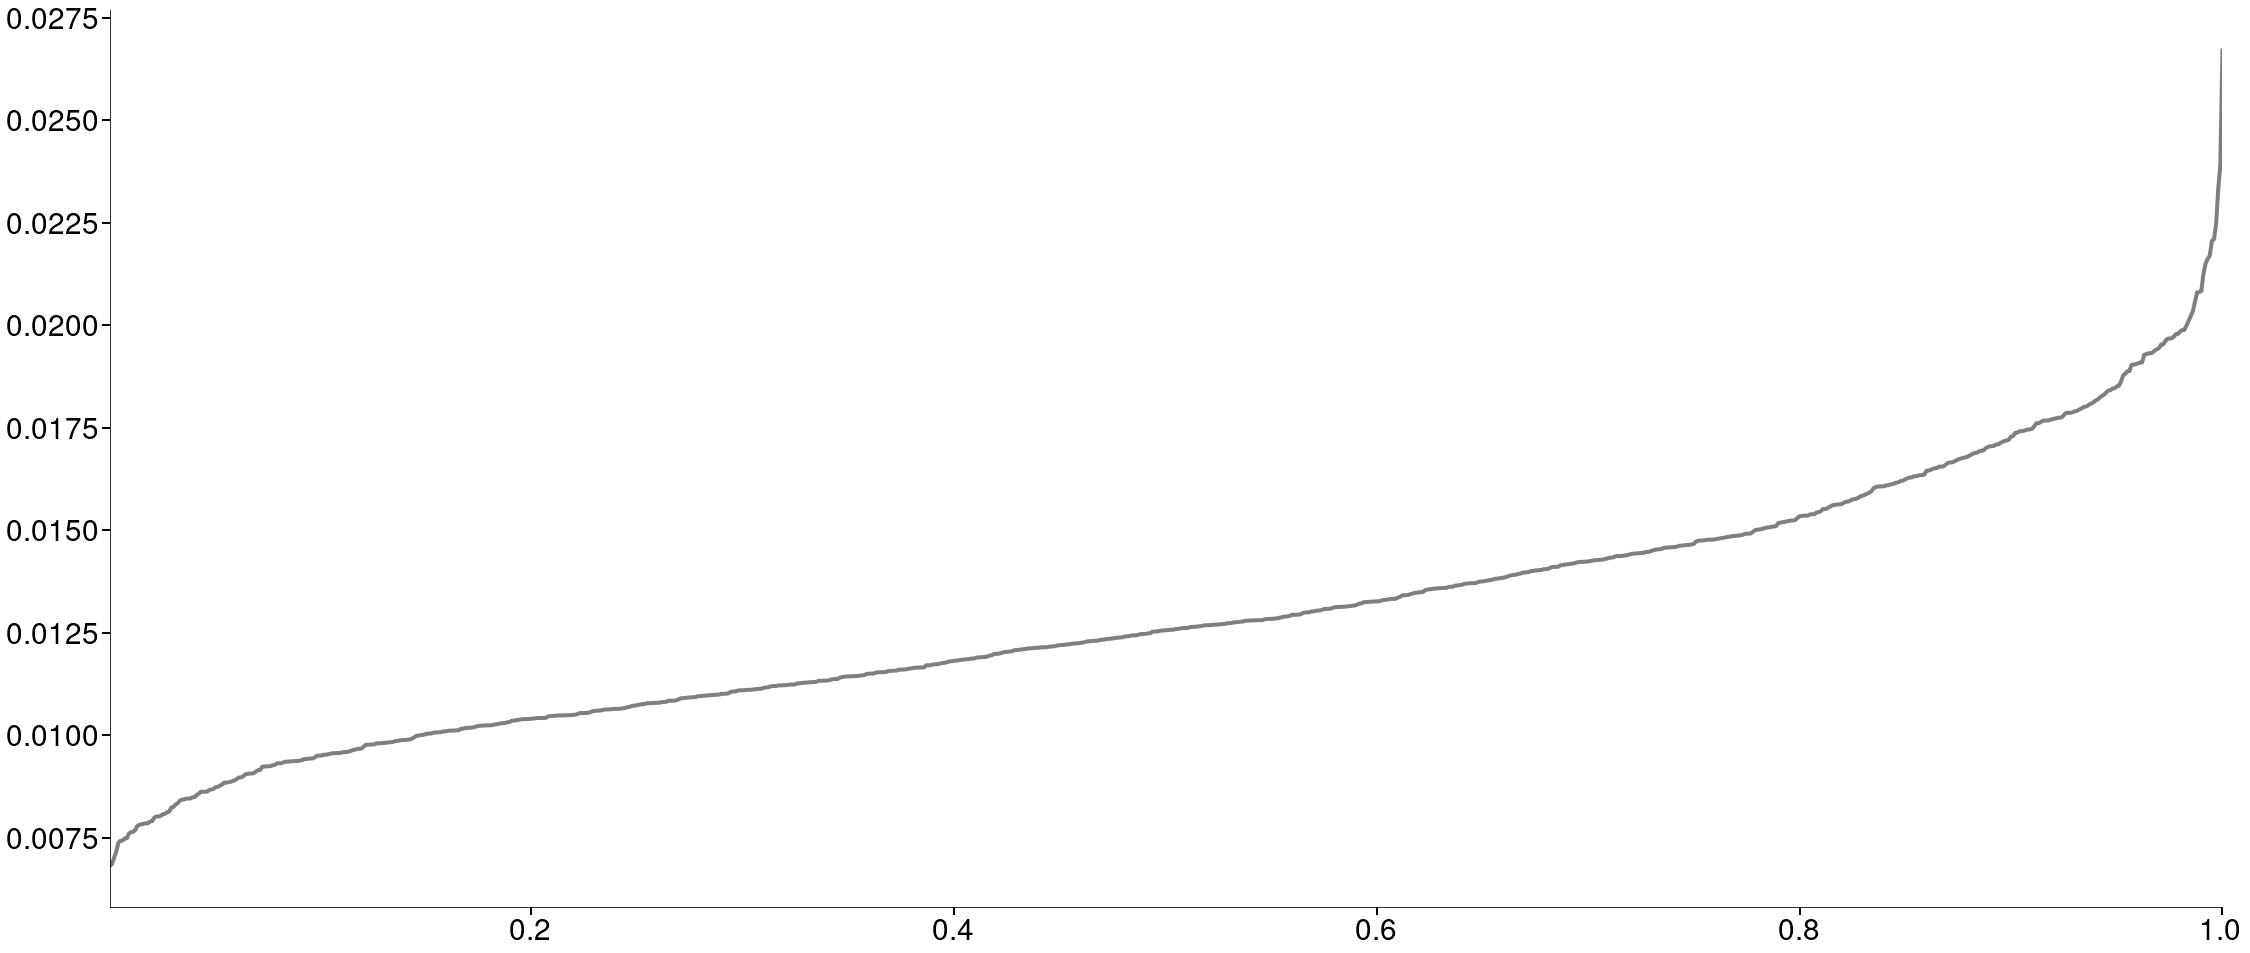

In [52]:
plot(sim_stats)

# Berkowitz's Test

* Exploits probability integral transform property $\hat{u}_{t}=F(y_{t}) $
* Re-transforms the data to a standard normal $\hat{\eta}_{t}=\Phi^{-1}(\hat{u}_{t})=\Phi^{-1}(F(y_{t}))$

$$\hat{u}_{t}\stackrel{iid}{\sim} U(0,1) \Rightarrow \hat{\eta}_{t}\stackrel{iid}{\sim} N(0,1)$$

* Test is a likelihood ratio test using an AR(1)

$$\hat{\eta}_{t}=\phi_{0}+\phi_{1}\hat{\eta}_{t-1}+\nu_{t}$$

* Correctly specified

$$H_{0}:\phi_{0}=0\cap\phi_{1}=0\cap\sigma^{2}=\mathrm{V}[\nu_{t}]=1 $$

* Likelihood ratio 

$$2\left(l(\eta_{t}|\hat{\phi}_{0},\hat{\phi}_{1},\hat{\sigma}^{2})-l(\eta_{t}|\phi_{0}=0,\phi_{1}=0,\sigma^{2}=1)\right)\sim\chi_{3}^{2}$$

In [53]:
from scipy import stats

u = tarch_skewt.model.distribution.cdf(
    tarch_skewt.std_resid, tarch_skewt.params.iloc[-2:]
)
norm = stats.norm.ppf(u)
from statsmodels.tsa.api import SARIMAX

ar_mod = SARIMAX(norm, order=(1, 0, 0), trend="c")
ar_res = ar_mod.fit()
with ar_mod.fix_params({"intercept": 0.0, "ar.L1": 0.0, "sigma2": 1.0}):
    ar_res_null = ar_mod.fit()
berkowitz_lr = 2 * (ar_res.llf - ar_res_null.llf)
berkowitz_pval = 1 - stats.chi2(3).cdf(berkowitz_lr)

# Berkowitz Test Results
## Skew $t$

In [54]:
summary(ar_res)

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,0.0073,0.022,0.339,0.735,-0.035,0.050
ar.L1,-0.0738,0.021,-3.463,0.001,-0.115,-0.032
sigma2,0.9951,0.030,33.004,0.000,0.936,1.054


In [55]:
pretty(f"Berkowitz stat: {berkowitz_lr:0.2f}, p-value: {100*berkowitz_pval:0.1f}%")

# Berkowitz's Test with Parameter Estimation Uncertainty

* Same issues as KS test
* Solution is the same - simulate the empirical CDF of the statistic

In [56]:
import warnings

warnings.simplefilter("ignore")
berkowitz_stats = []
for i in range(1000):
    if i and i % 50 == 0:
        print(f"Iteration {i}")
    data = tarch_skewt.model.simulate(tarch_skewt.params, sp500_weekly.shape[0]).data
    am = arch_model(data, o=1, power=1.0, dist="skewt")
    res = am.fit(starting_values=tarch_skewt.params, disp="off")
    u = res.model.distribution.cdf(res.std_resid, res.params.iloc[-2:])

    norm = stats.norm.ppf(u)

    ar_mod = SARIMAX(norm, order=(1, 0, 0), trend="c")
    ar_res = ar_mod.fit()
    ar_res.summary()
    with ar_mod.fix_params({"intercept": 0.0, "ar.L1": 0.0, "sigma2": 1.0}):
        ar_res_null = ar_mod.fit()
    lr_sim = 2 * (ar_res.llf - ar_res_null.llf)
    berkowitz_stats.append(lr_sim)

Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 500
Iteration 550
Iteration 600
Iteration 650
Iteration 700
Iteration 750
Iteration 800
Iteration 850
Iteration 900
Iteration 950


In [57]:
emp_dist = pd.Series(berkowitz_stats).sort_values()
n = emp_dist.shape[0]
emp_dist.index = np.linspace(1 / n, 1, n)

In [58]:
berkowitz_pee_pval = (berkowitz_lr < emp_dist).mean()
pretty(
    f"Original P-value: {100*berkowitz_pval:0.1f}%, "
    f"Accounting for PEE: {100*berkowitz_pee_pval:0.1f}%"
)

In [59]:
def plot_berkowitz():
    asymp_dist = pd.Series(stats.chi2(3).ppf(emp_dist.index), index=emp_dist.index)
    both = pd.DataFrame({"With PEE": emp_dist, "No PEE": asymp_dist})
    plot(both)
    ax = plt.gca()
    yl = ax.set_ylim(0, both.iloc[:-5].max().max())

# The effect of PEE on the Berkowitz Test

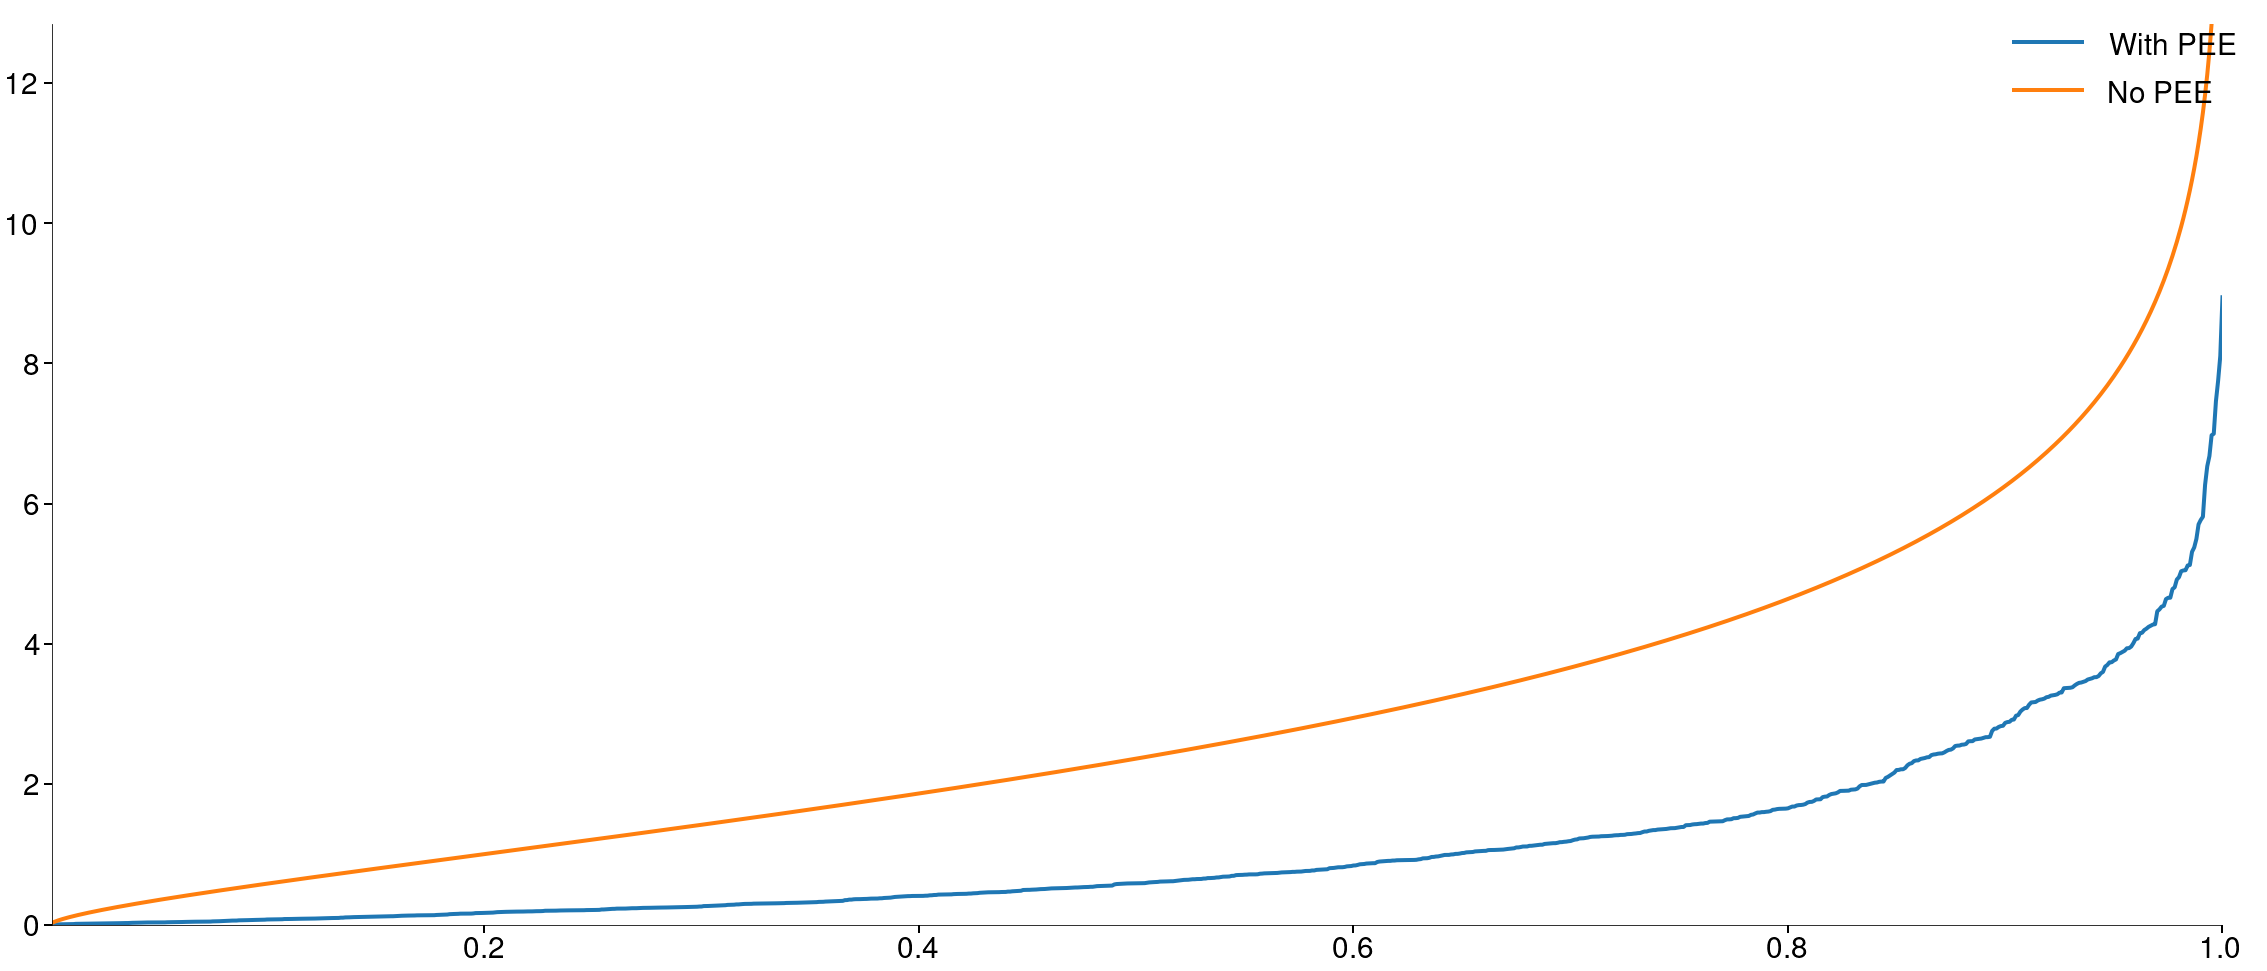

In [60]:
plot_berkowitz()

# Next Week

* Final Classes with Tales
* Office Hours

# Schedule TBD

* Revision Class